<!-- meta data for latex export -->
\setcounter{page}{0}
\title{Fixed Income Derivatives: Risk Management and Financial
Institutions \\ Exam January 2024}
\author{Johan Ølgaard}
\date{January 17, 2025}
\maketitle
\setcounter{secnumdepth}{0}

In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
import numpy as np
from scipy.optimize import minimize

import sys
import os
sys.path.append(os.path.abspath("../Files"))

# import own module
import fixed_income_derivatives_E2024 as fid
import plotting as plot

%load_ext autoreload
%autoreload 2

### Problem 1
#### a)

In [2]:
T = np.array([0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7, 10])
R = np.array([0.0334, 0.0352, 0.0375, 0.0392, 0.0405, 0.0422, 0.0433, 0.0445, 0.0451, 0.0455, 0.0459, 0.0462])
sigma = 0.08
param0 = 0.025, 1.5, 0.07
result = minimize(fid.fit_cir_no_sigma_obj, param0, args=(sigma, R, T), method='Nelder-Mead', options={'xatol': 1e-8, 'disp': False})
r0, a, b = result.x
# print(f'Parameter estimates from fit:\nr0 = {r0:.4f}\na = {a:.4f}\nb = {b:.4f}')

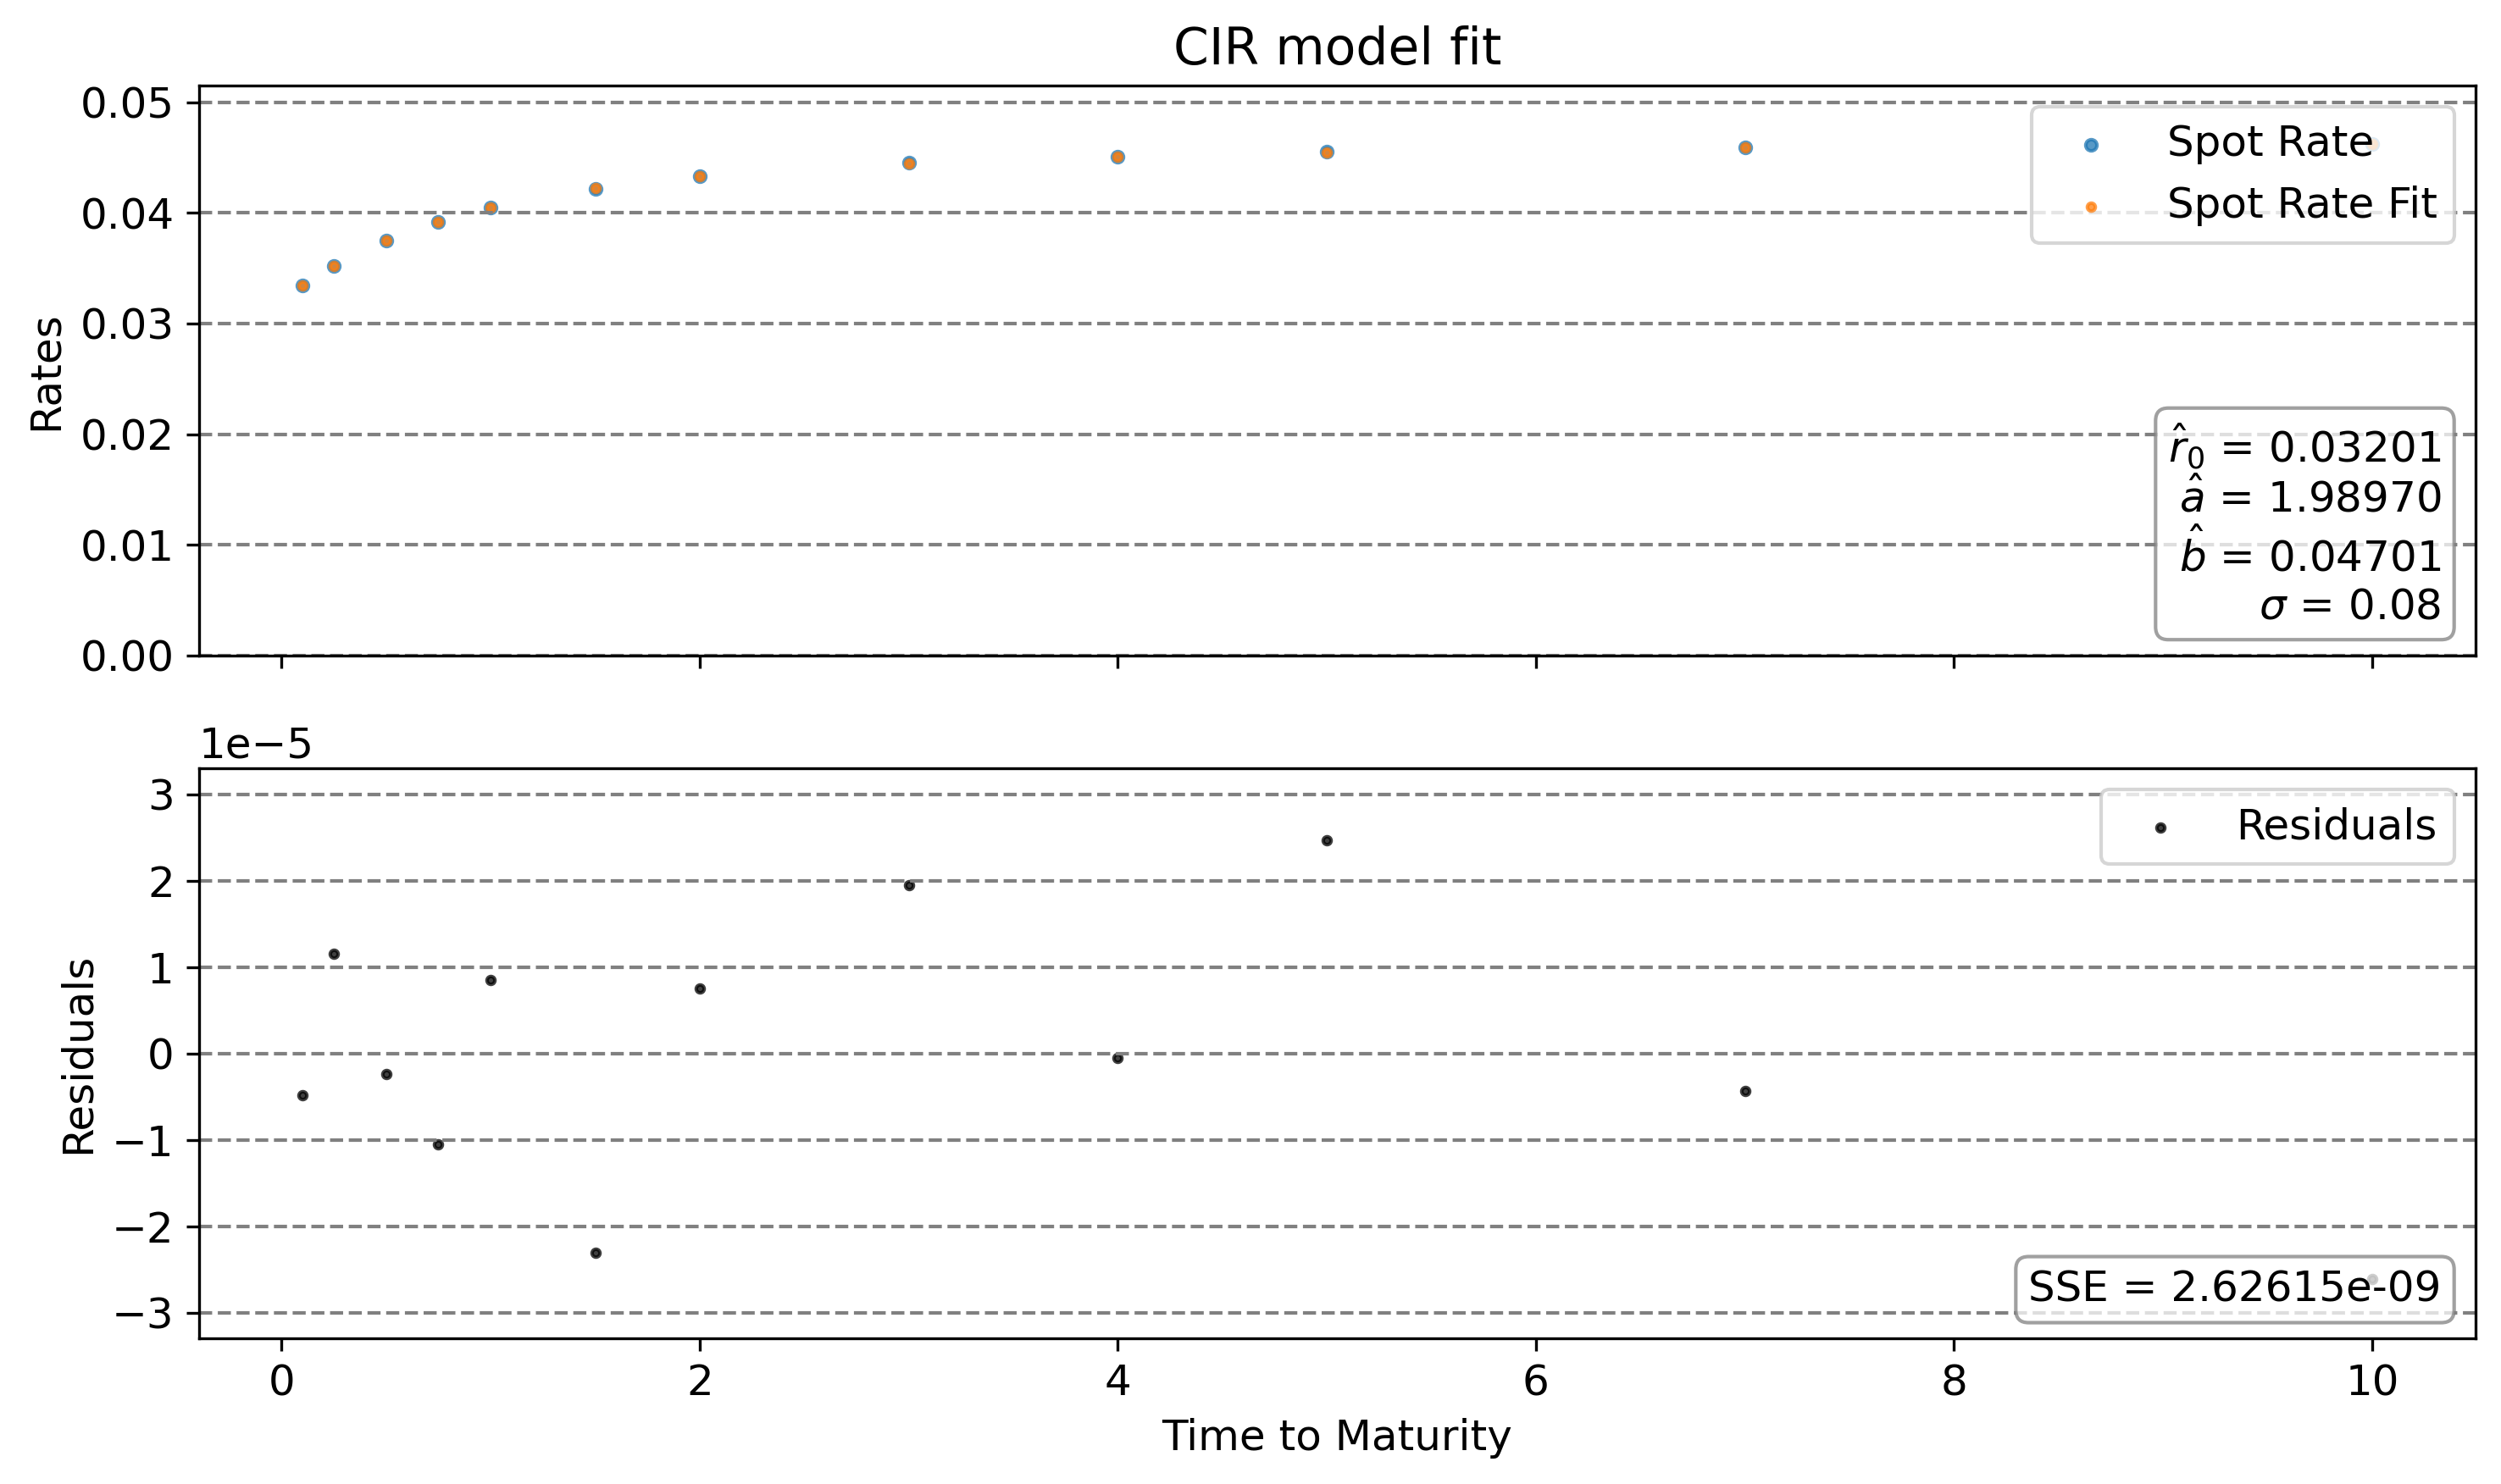

In [3]:
R_fit = fid.spot_rate_cir(r0,a,b,sigma, T)
residuals = R - R_fit
fit = [{'label':'Spot Rate','x':T,'y':R,'s':40},
       {'label':'Spot Rate Fit','x':T,'y':R_fit}]
res = [{'label':'Residuals','x':T,'y':residuals}]
text = {'$\hat{r}_0$':r0,'$\hat{a}$':a,'$\hat{b}$':b,'$\sigma$':f'{sigma:.2f}'}
text_res = {'SSE':result.fun}
plot.fit(fit,res,'CIR model fit',text, text_res)

From the plot above we see that the fitted spot rate is on top of the actual spot rate with an SSE of $2.63\cdot10^{-9}$.

#### b)

In [4]:
seed = 2025
M_simul, T_simul = 10000, 10
np.random.seed(seed)
t_simul = np.linspace(0, T_simul, M_simul+1)
r_simul = fid.simul_cir(r0,a,b,sigma,M_simul,T_simul,method='exact')

size_ci = 0.99
lb, ub = fid.ci_cir(r0,a,b,sigma,t_simul,size_ci)
lb_sd, ub_sd = fid.ci_cir(r0,a,b,sigma,100,size_ci) # assuming stationary distribution is reached after 100 years

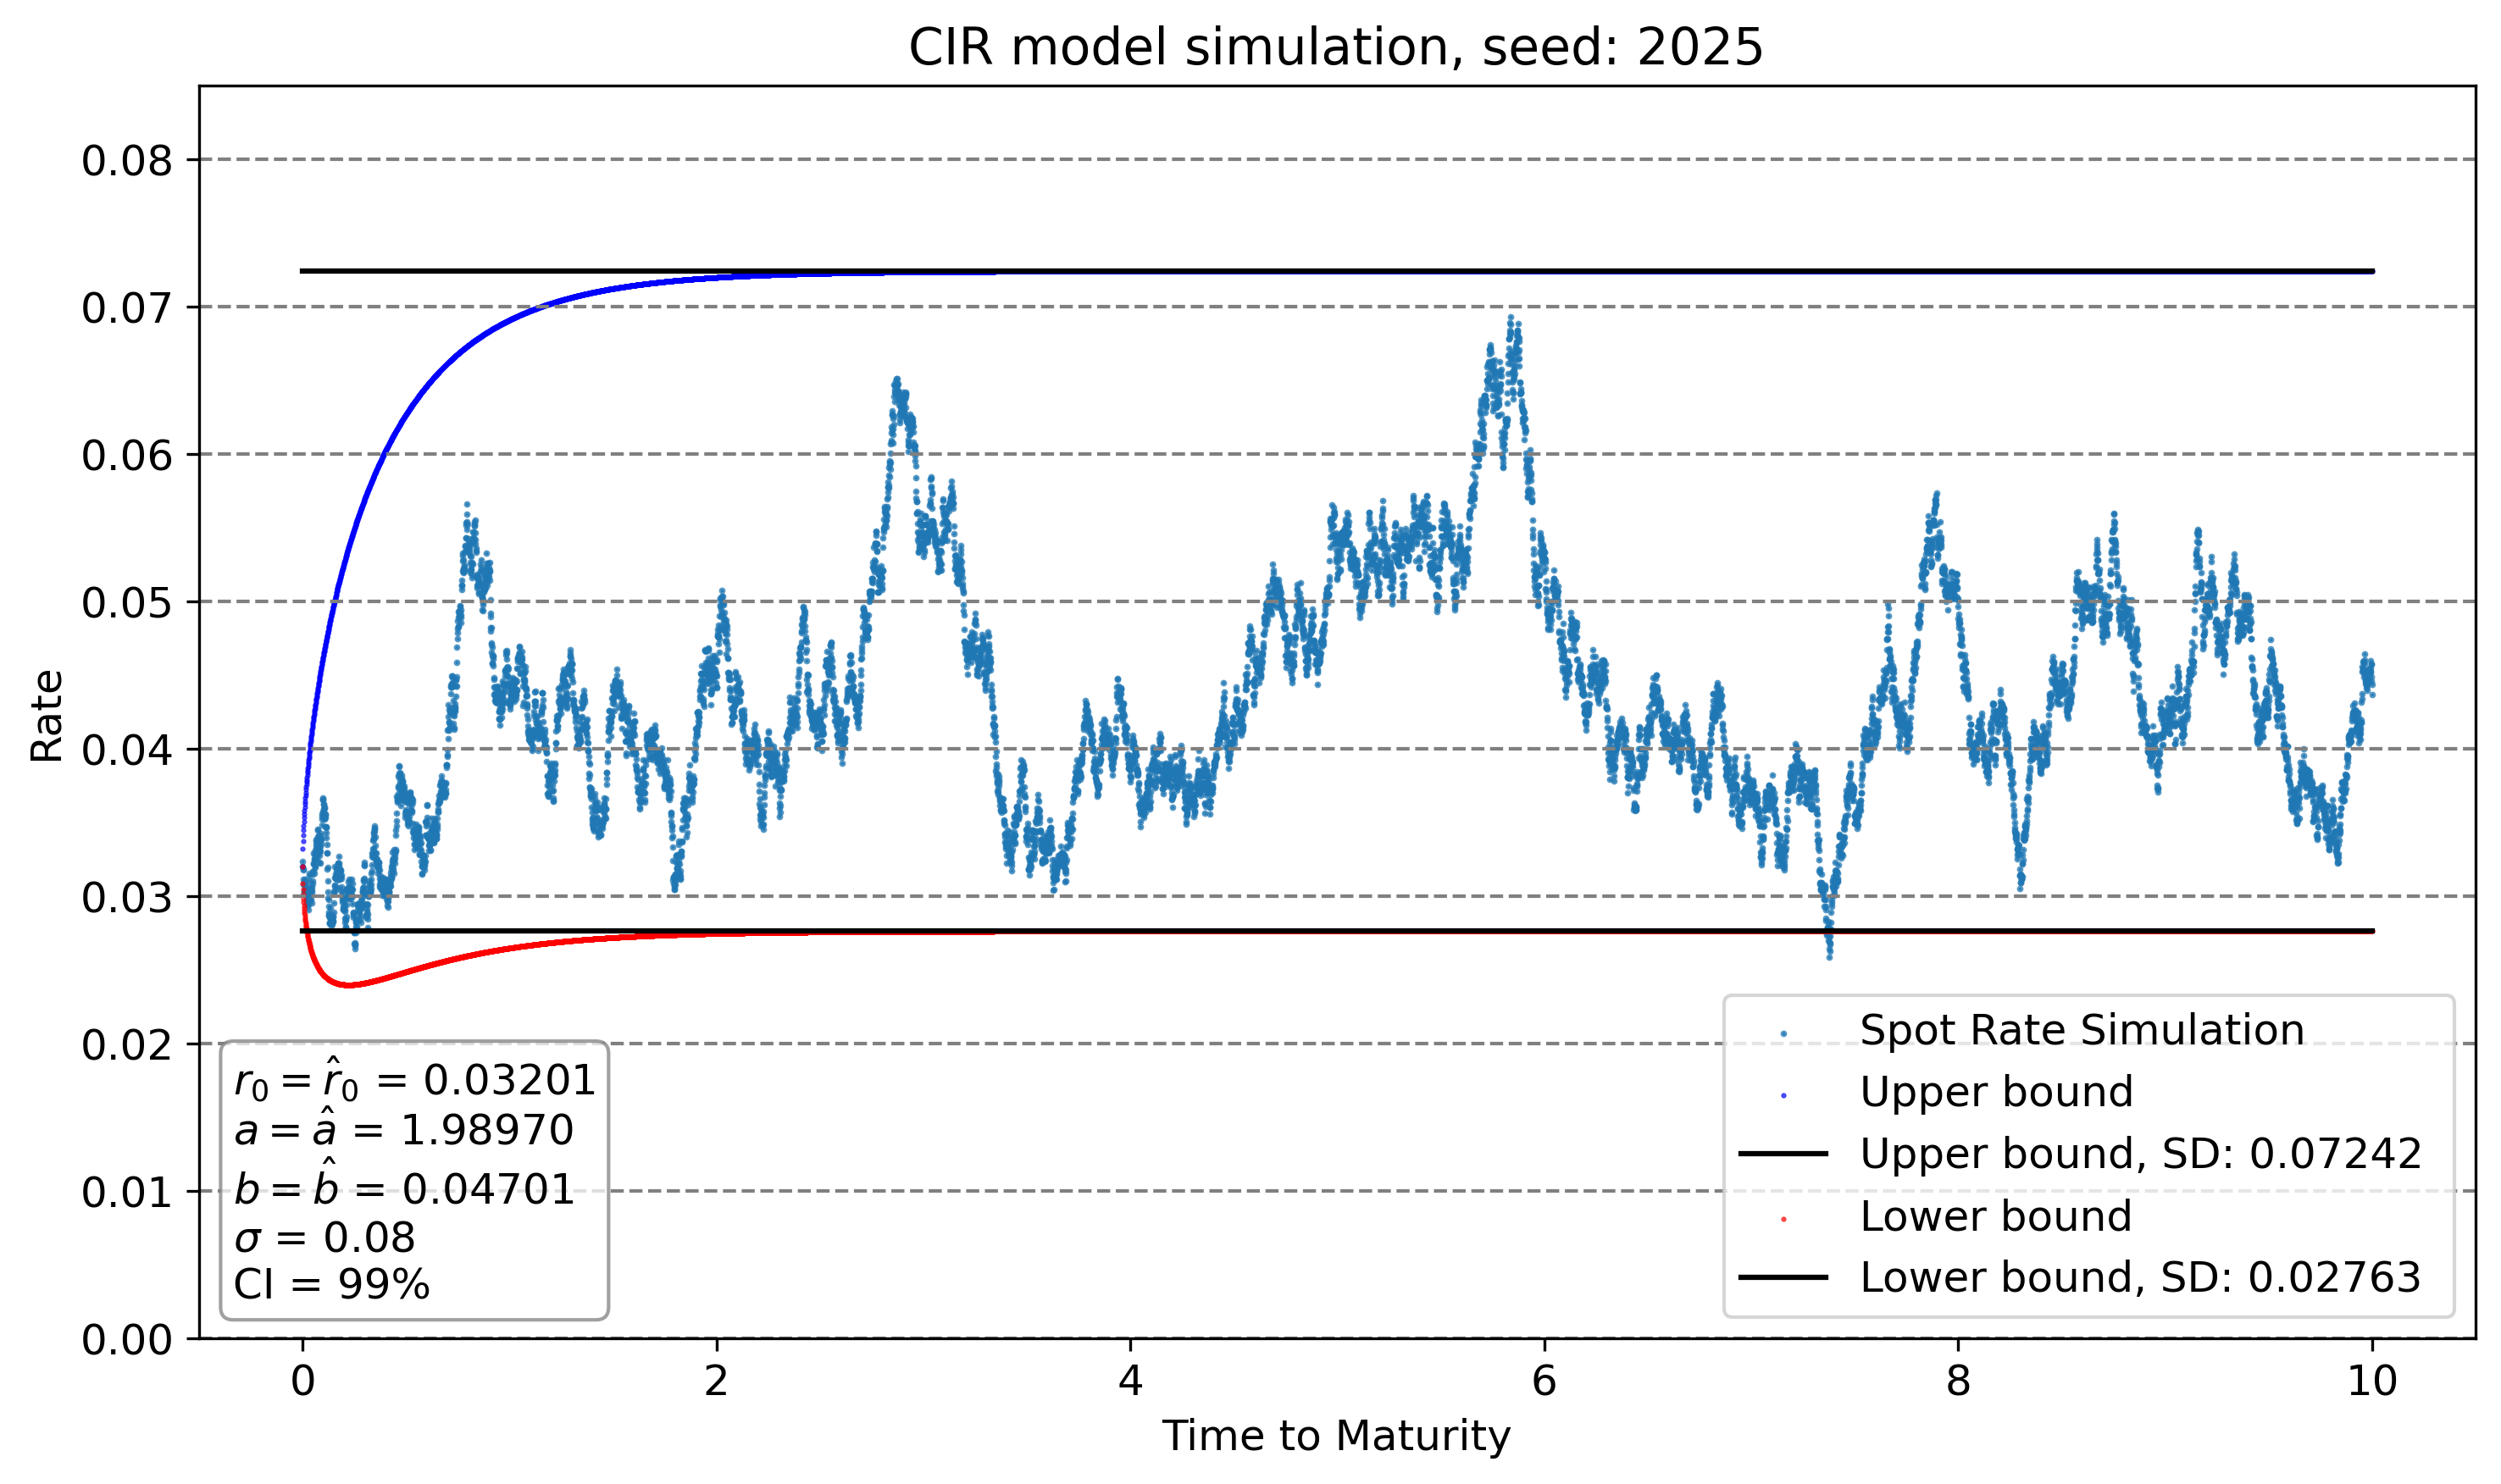

In [5]:
simul_plot = [{'label':'Spot Rate Simulation','x':t_simul,'y':r_simul,'s':3},
              {'label':'Upper bound','x':t_simul,'y':ub,'color':'blue', 's':1},
              {'label':f'Upper bound, SD: {ub_sd:.5f}', 'x':np.array([0,10]), 'y':ub_sd*np.ones(2), 'color':'black', 'type':'line'},
              {'label':'Lower bound','x':t_simul,'y':lb,'color':'red', 's':1},
              {'label':f'Lower bound, SD: {lb_sd:.5f}', 'x':np.array([0,10]), 'y':lb_sd*np.ones(2), 'color':'black', 'type':'line'}]
text = {'$r_0=\hat{r}_0$':r0,'$a=\hat{a}$':a,'$b=\hat{b}$':b,'$\sigma$':f'{sigma:.2f}','CI':f'{size_ci:.0%}'}
plot.rates(simul_plot,title=f'CIR model simulation, seed: {seed}',text=text)

#### c)

In [6]:
M_simul, T_simul, N_simul = 1000, 2, 1000
t_simul = np.linspace(0, T_simul, M_simul+1)
chi_derivative, price_derivative, price_derivative_plot = np.zeros(N_simul), np.zeros(N_simul), np.zeros(N_simul)

np.random.seed(seed)
for i in range(N_simul):
    r_simul = fid.simul_cir(r0,a,b,sigma,M_simul,T_simul,method='euler')
    chi_derivative[i] = r_simul.max()
    price_derivative[i] = np.exp(-(T_simul/M_simul)*sum(r_simul))*chi_derivative[i]
    price_derivative_plot[i] = sum(price_derivative[0:i+1])/(i+1)
print(f'Fair value of the complex derivative: {price_derivative_plot[-1]:.5f}')

Fair value of the complex derivative: 0.05437


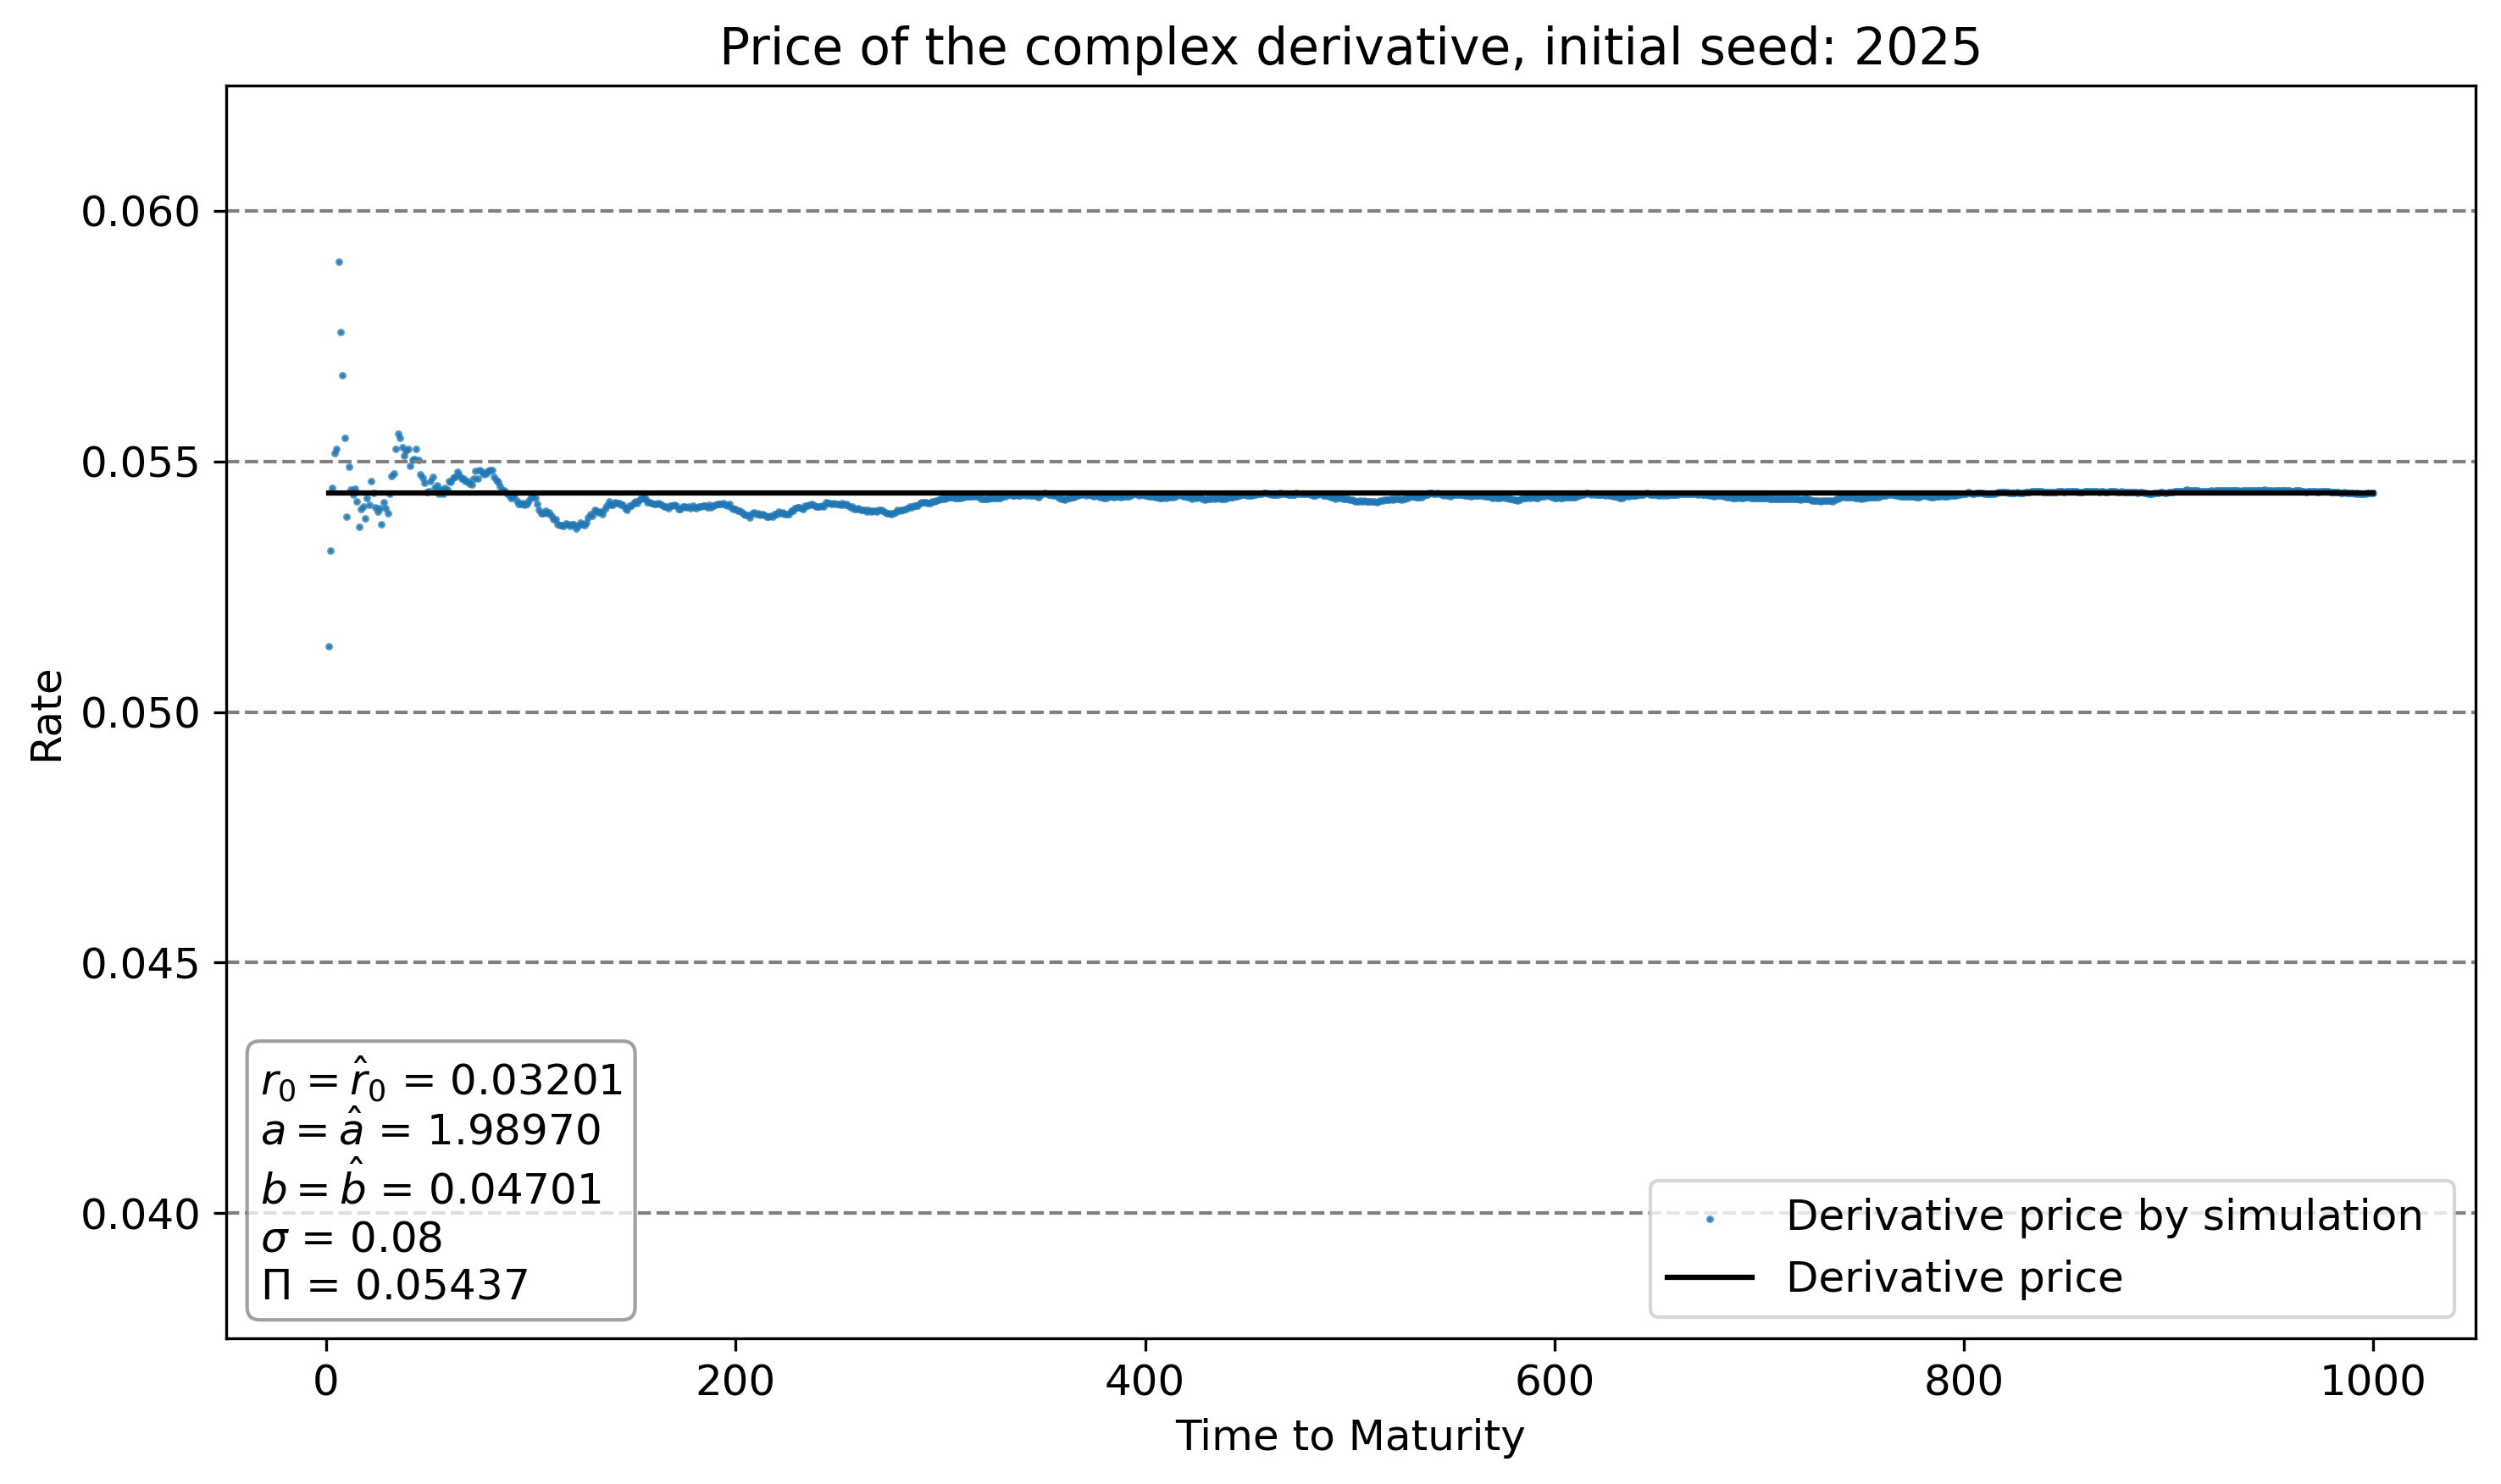

In [7]:
derivative_plot = [{'label':'Derivative price by simulation','x':np.arange(1,N_simul+1),'y':price_derivative_plot, 's':5},
                   {'label':'Derivative price','x':np.array([1,N_simul]),'y':np.array([price_derivative_plot[-1],price_derivative_plot[-1]]), 'color':'black', 'type':'line'}]
text = {'$r_0=\hat{r}_0$':r0,'$a=\hat{a}$':a,'$b=\hat{b}$':b,'$\sigma$':f'{sigma:.2f}','$\Pi$':price_derivative_plot[-1]}
plot.rates(derivative_plot,title=f'Price of the complex derivative, initial seed: {seed}',text=text,yrange=[0.0375,0.0625,0.005])

I estimate the fair value of the complex derivative to be $0.05422$ when using the `exact` scheme in a discrete way. The discretization misses potential peaks in the continous time between each point and hence underestimates the value of the complex derivative. This could be mitigated by increasing the number of grid points, $M$, but problem would still persist on a theoretical level.


### Problem 2
#### a)

In [8]:
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.02927}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03161},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03295},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03418},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.03531},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.03635},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.03731},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.03819},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.03900},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.03976}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.03824, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04083, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04242, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04346, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04468, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.04561, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.04633, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.04667, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.04700, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market
interpolation_options = {"method":"nelson_siegel","transition": 'smooth'}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options=interpolation_options)
T_inter = np.linspace(0, 30, 10*12*30+1)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter=T_inter, T=T_fit, R=R_fit, interpolation_options=interpolation_options)

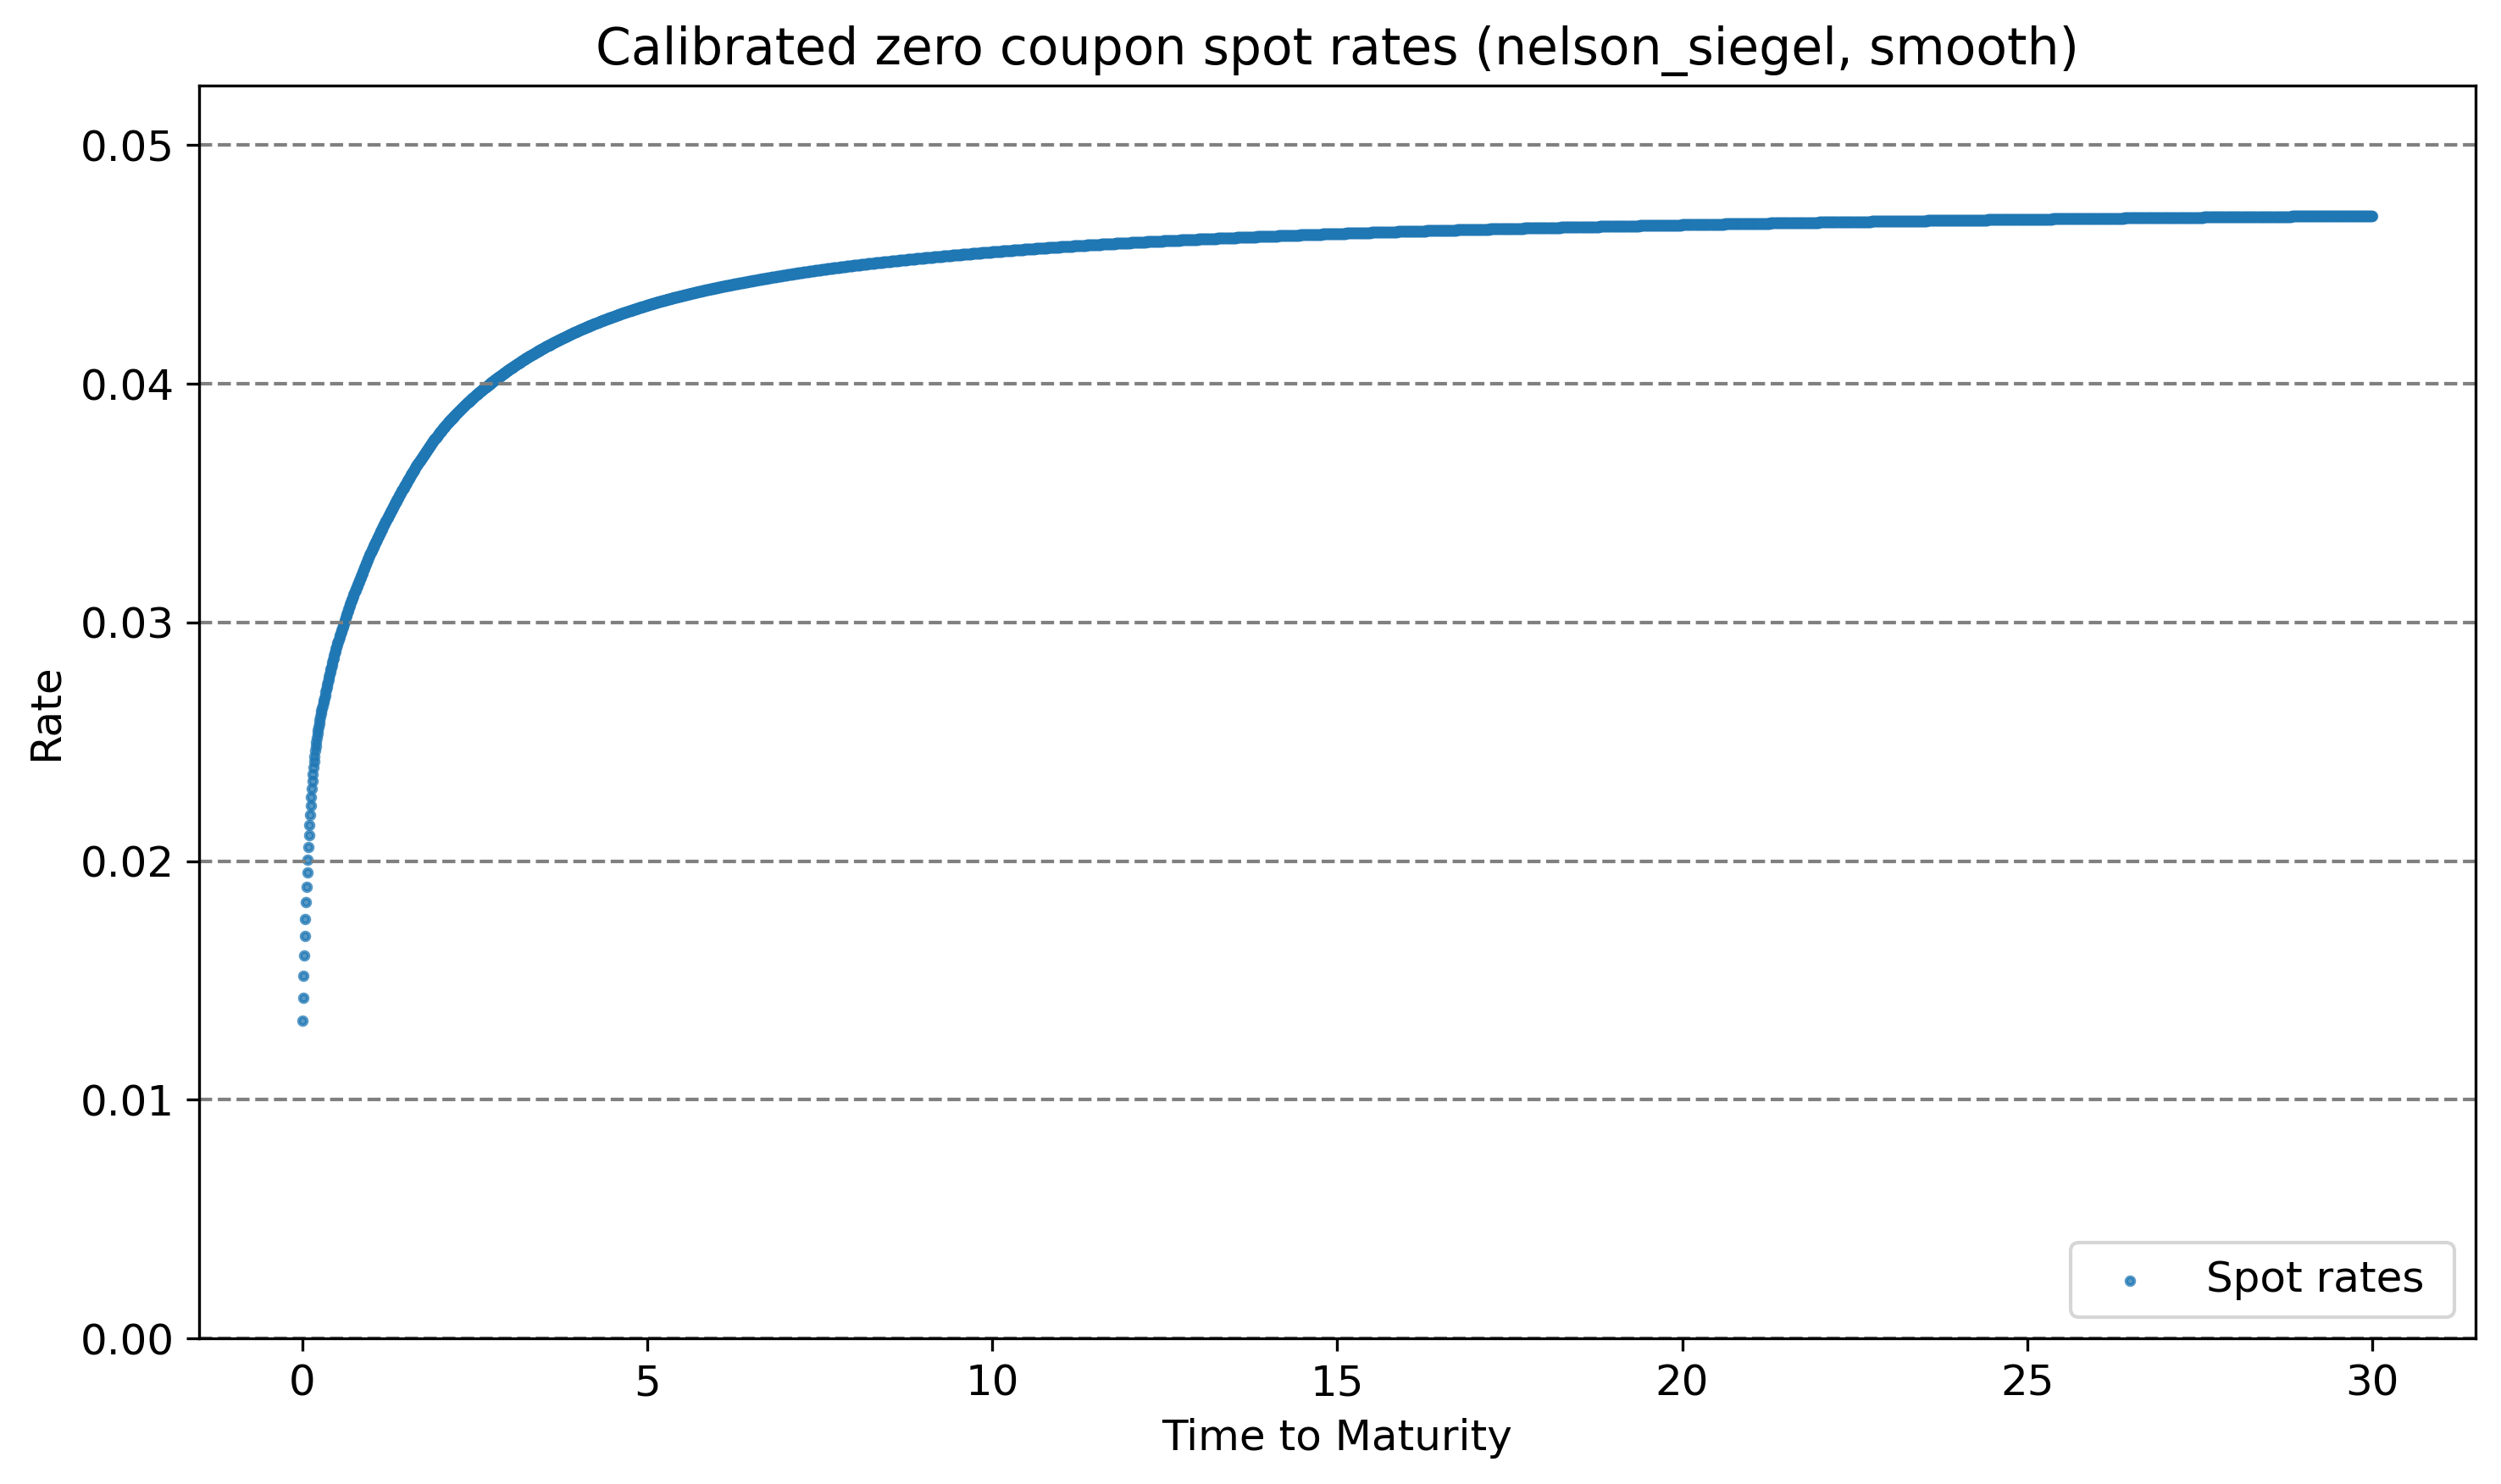

In [9]:
fit = [{'label':'Spot rates', 'x':T_inter, 'y':R_inter},]
plot.rates(fit,title=f'Calibrated zero coupon spot rates ({interpolation_options["method"]}, {interpolation_options["transition"]})')

In [10]:
T_report = np.array([0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30])
R_report = np.zeros(len(T_report))
print('Zero coupon spot rates for selected maturities:')
for i, t in enumerate(T_report):
    R_report[i] = fid.find_value_return_value(t, T_inter, R_inter, precision=1e-8)[1][0][1]
    print(f'{T_report[i]:.1f}:  {R_report[i]:.5f}')

Zero coupon spot rates for selected maturities:
0.5:  0.02906
1.0:  0.03301
2.0:  0.03800
3.0:  0.04061
5.0:  0.04330
7.0:  0.04456
10.0:  0.04553
15.0:  0.04629
20.0:  0.04666
30.0:  0.04705


#### b)

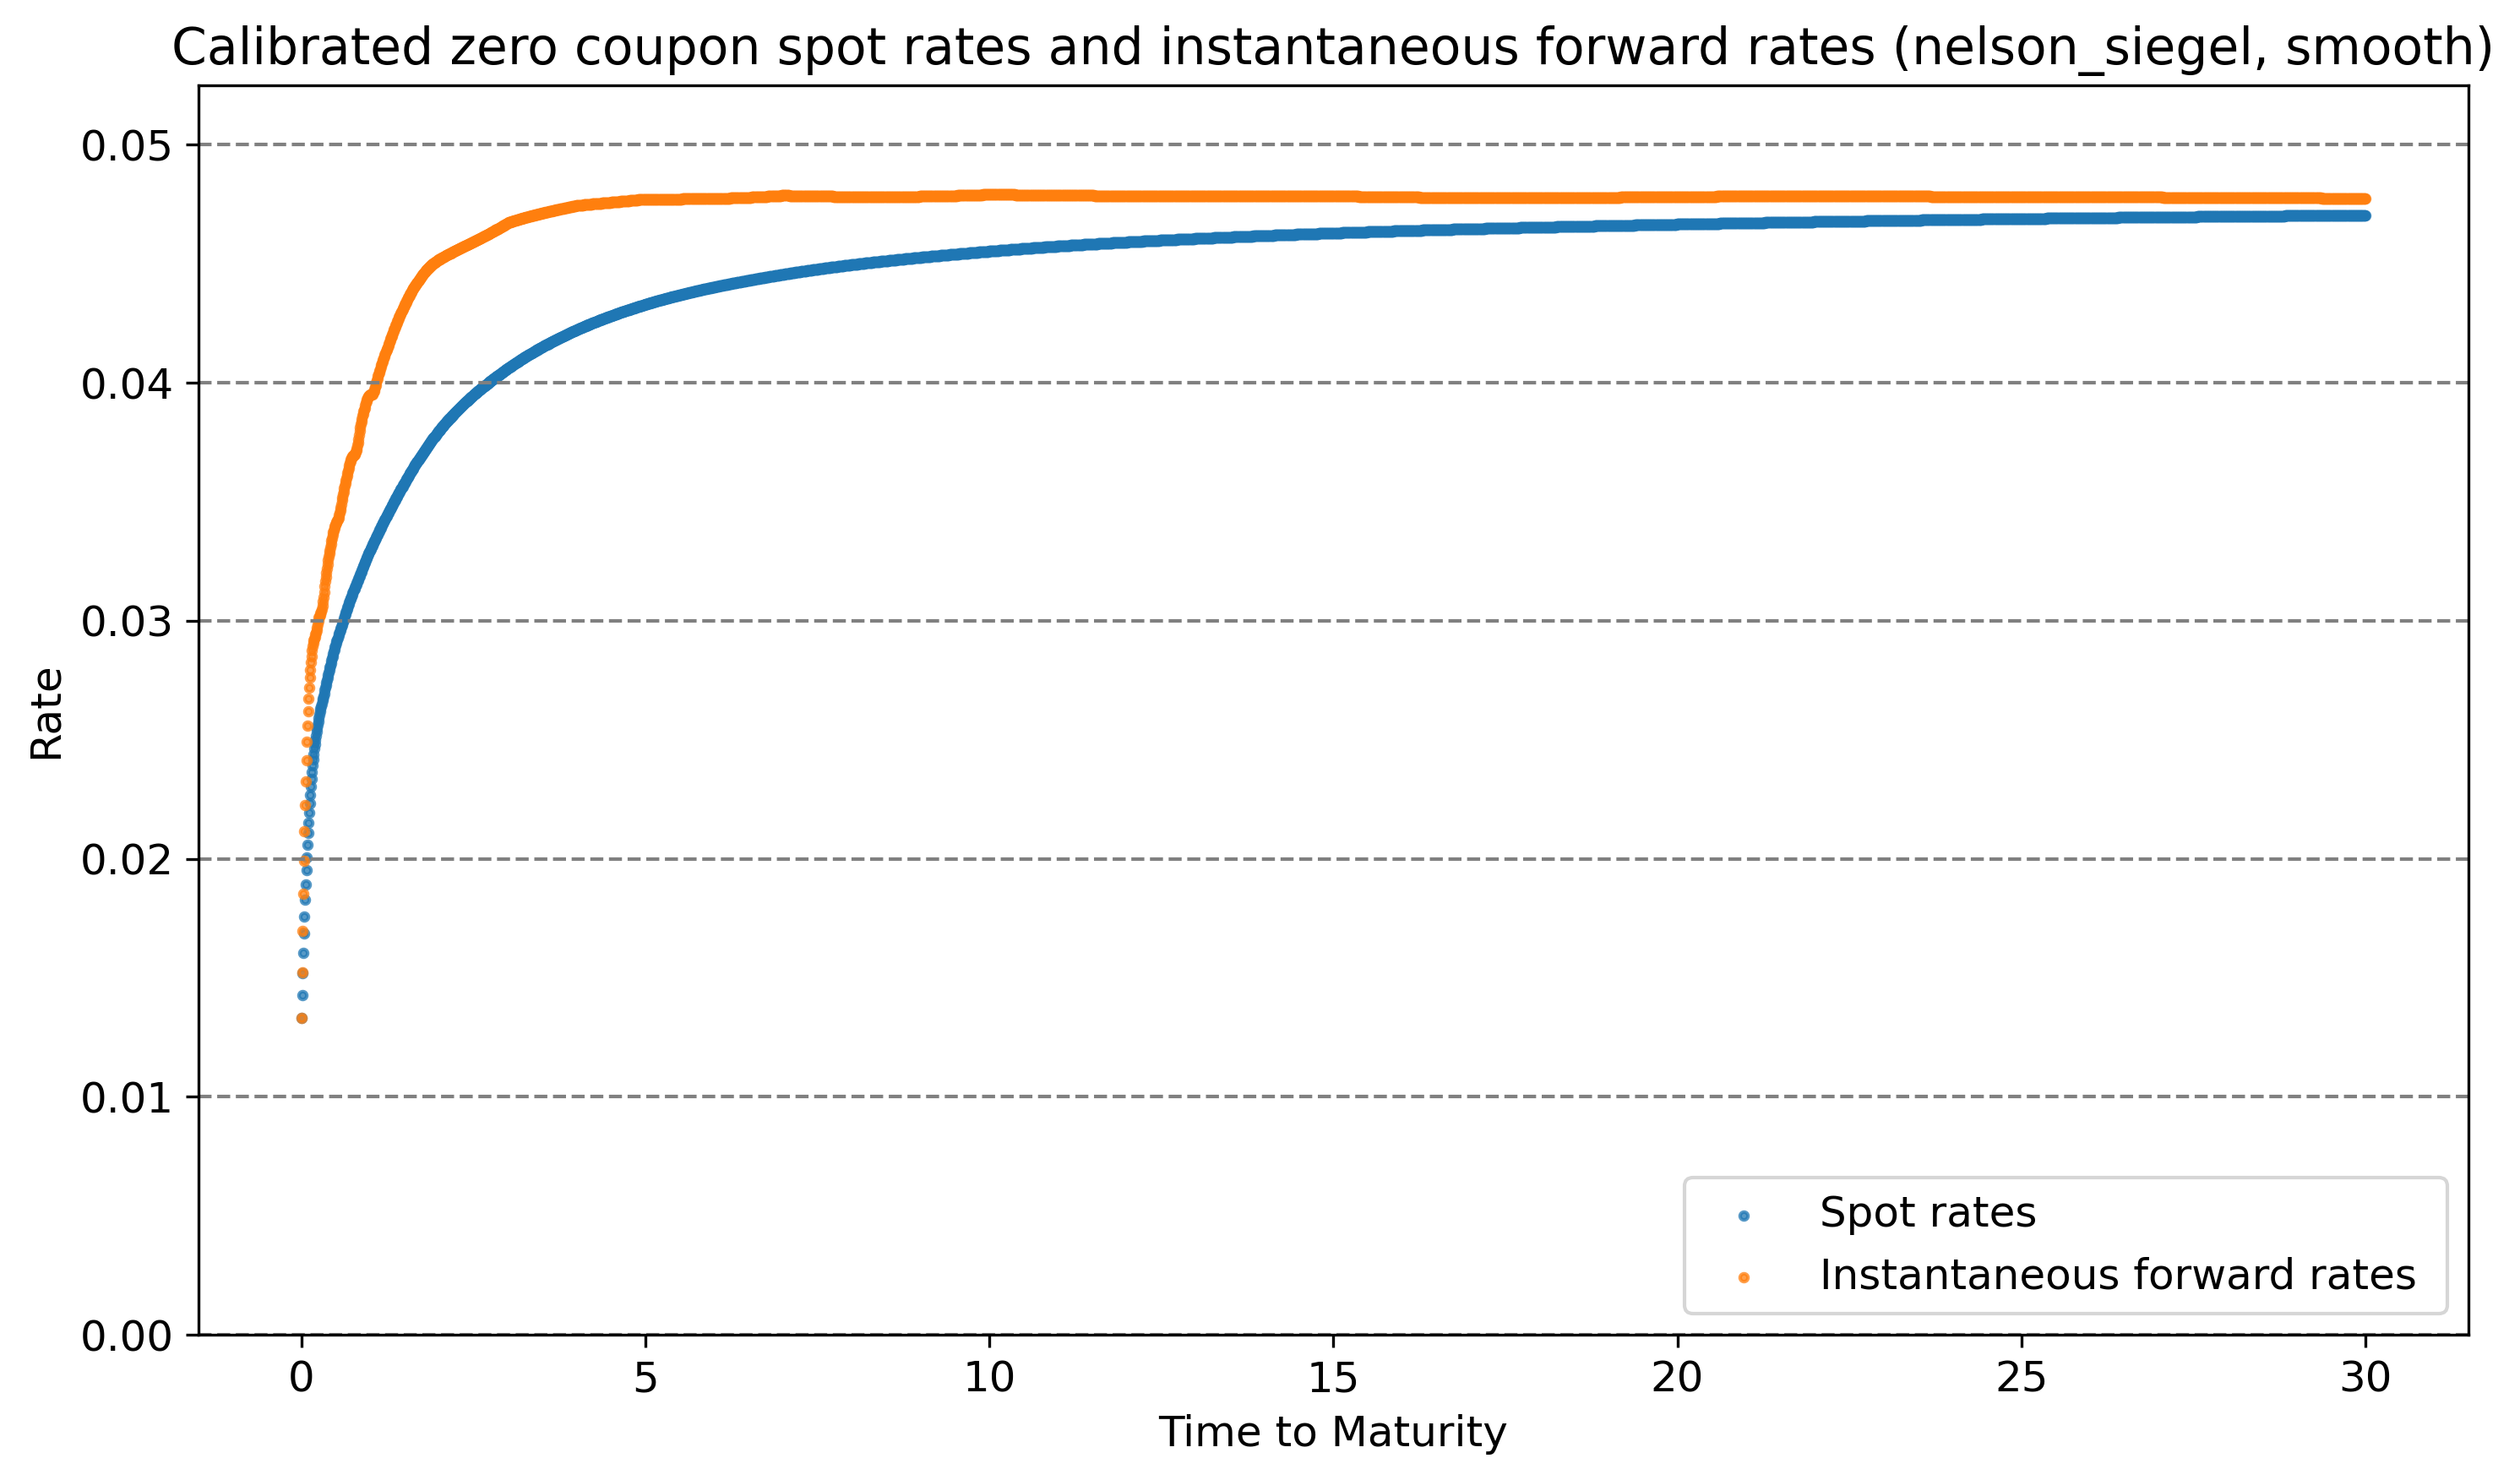

In [11]:
fit.append({'label':'Instantaneous forward rates', 'x':T_inter, 'y':f_inter})
plot.rates(fit,title=f'Calibrated zero coupon spot rates and instantaneous forward rates ({interpolation_options["method"]}, {interpolation_options["transition"]})')

I have fitted the instantaneous forward rate curve to the data using the Nelson-Siegel method using a smooth transition, which results in a smooth curve as if the price of the ZCB was differentiable unlike if I had made a linear interpolation, though it obviously is calculated discretely and hence we do not have the actual derivative of the price.

#### c)


In [12]:
# bumping all points
T_bump = T_inter
size_bump = 1/10000
swap_id = 14
R_bump, p_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0, 0, data[swap_id]['maturity'], data[swap_id]['fixed_freq'], T_inter, p_bump)
DV01 = (R_swap_bump - data[swap_id]['rate'])*S_swap_bump
print(f'DV01 for swap with maturity {data[swap_id]["maturity"]}Y when bumping all ZCB spot rates: {DV01*10000:.5f} bps')

# bumping individual points:
T_bump = [1,2,3,5,7]
DV01s = np.zeros(len(T_bump))
print(f'DV01 for swap with maturity {data[swap_id]["maturity"]}Y when bumping individual ZCB spot rates:')
for i, t_bump in enumerate(T_bump):
    R_bump, p_bump = fid.spot_rate_bump(t_bump,size_bump,T_inter,R_inter,p_inter)
    R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0, 0, data[swap_id]['maturity'], data[swap_id]['fixed_freq'], T_inter, p_bump)
    DV01s[i] = (R_swap_bump - data[swap_id]['rate'])*S_swap_bump
    print(f'T = {t_bump:.1f}: {DV01s[i]*10000:.5f} bps')

DV01 for swap with maturity 7Y when bumping all ZCB spot rates: 6.06685 bps
DV01 for swap with maturity 7Y when bumping individual ZCB spot rates:
T = 1.0: 0.01157 bps
T = 2.0: 0.03137 bps
T = 3.0: 0.04928 bps
T = 5.0: 0.07989 bps
T = 7.0: 5.22694 bps


I find that when bumping all ZCB rates at the semiannual fixed frequency up by 1 bp I get DV01 of 6.067 bps while. From bumping individually we find that the DV01 is increasing with maturity but almost entirely exposed to the spot rate with same maturity as the swap itself. This reveals that though seemingly very different, an interest rate swap behaves much like a zero coupon bond in terms of delta risk exposure

### Problem 3
#### a)

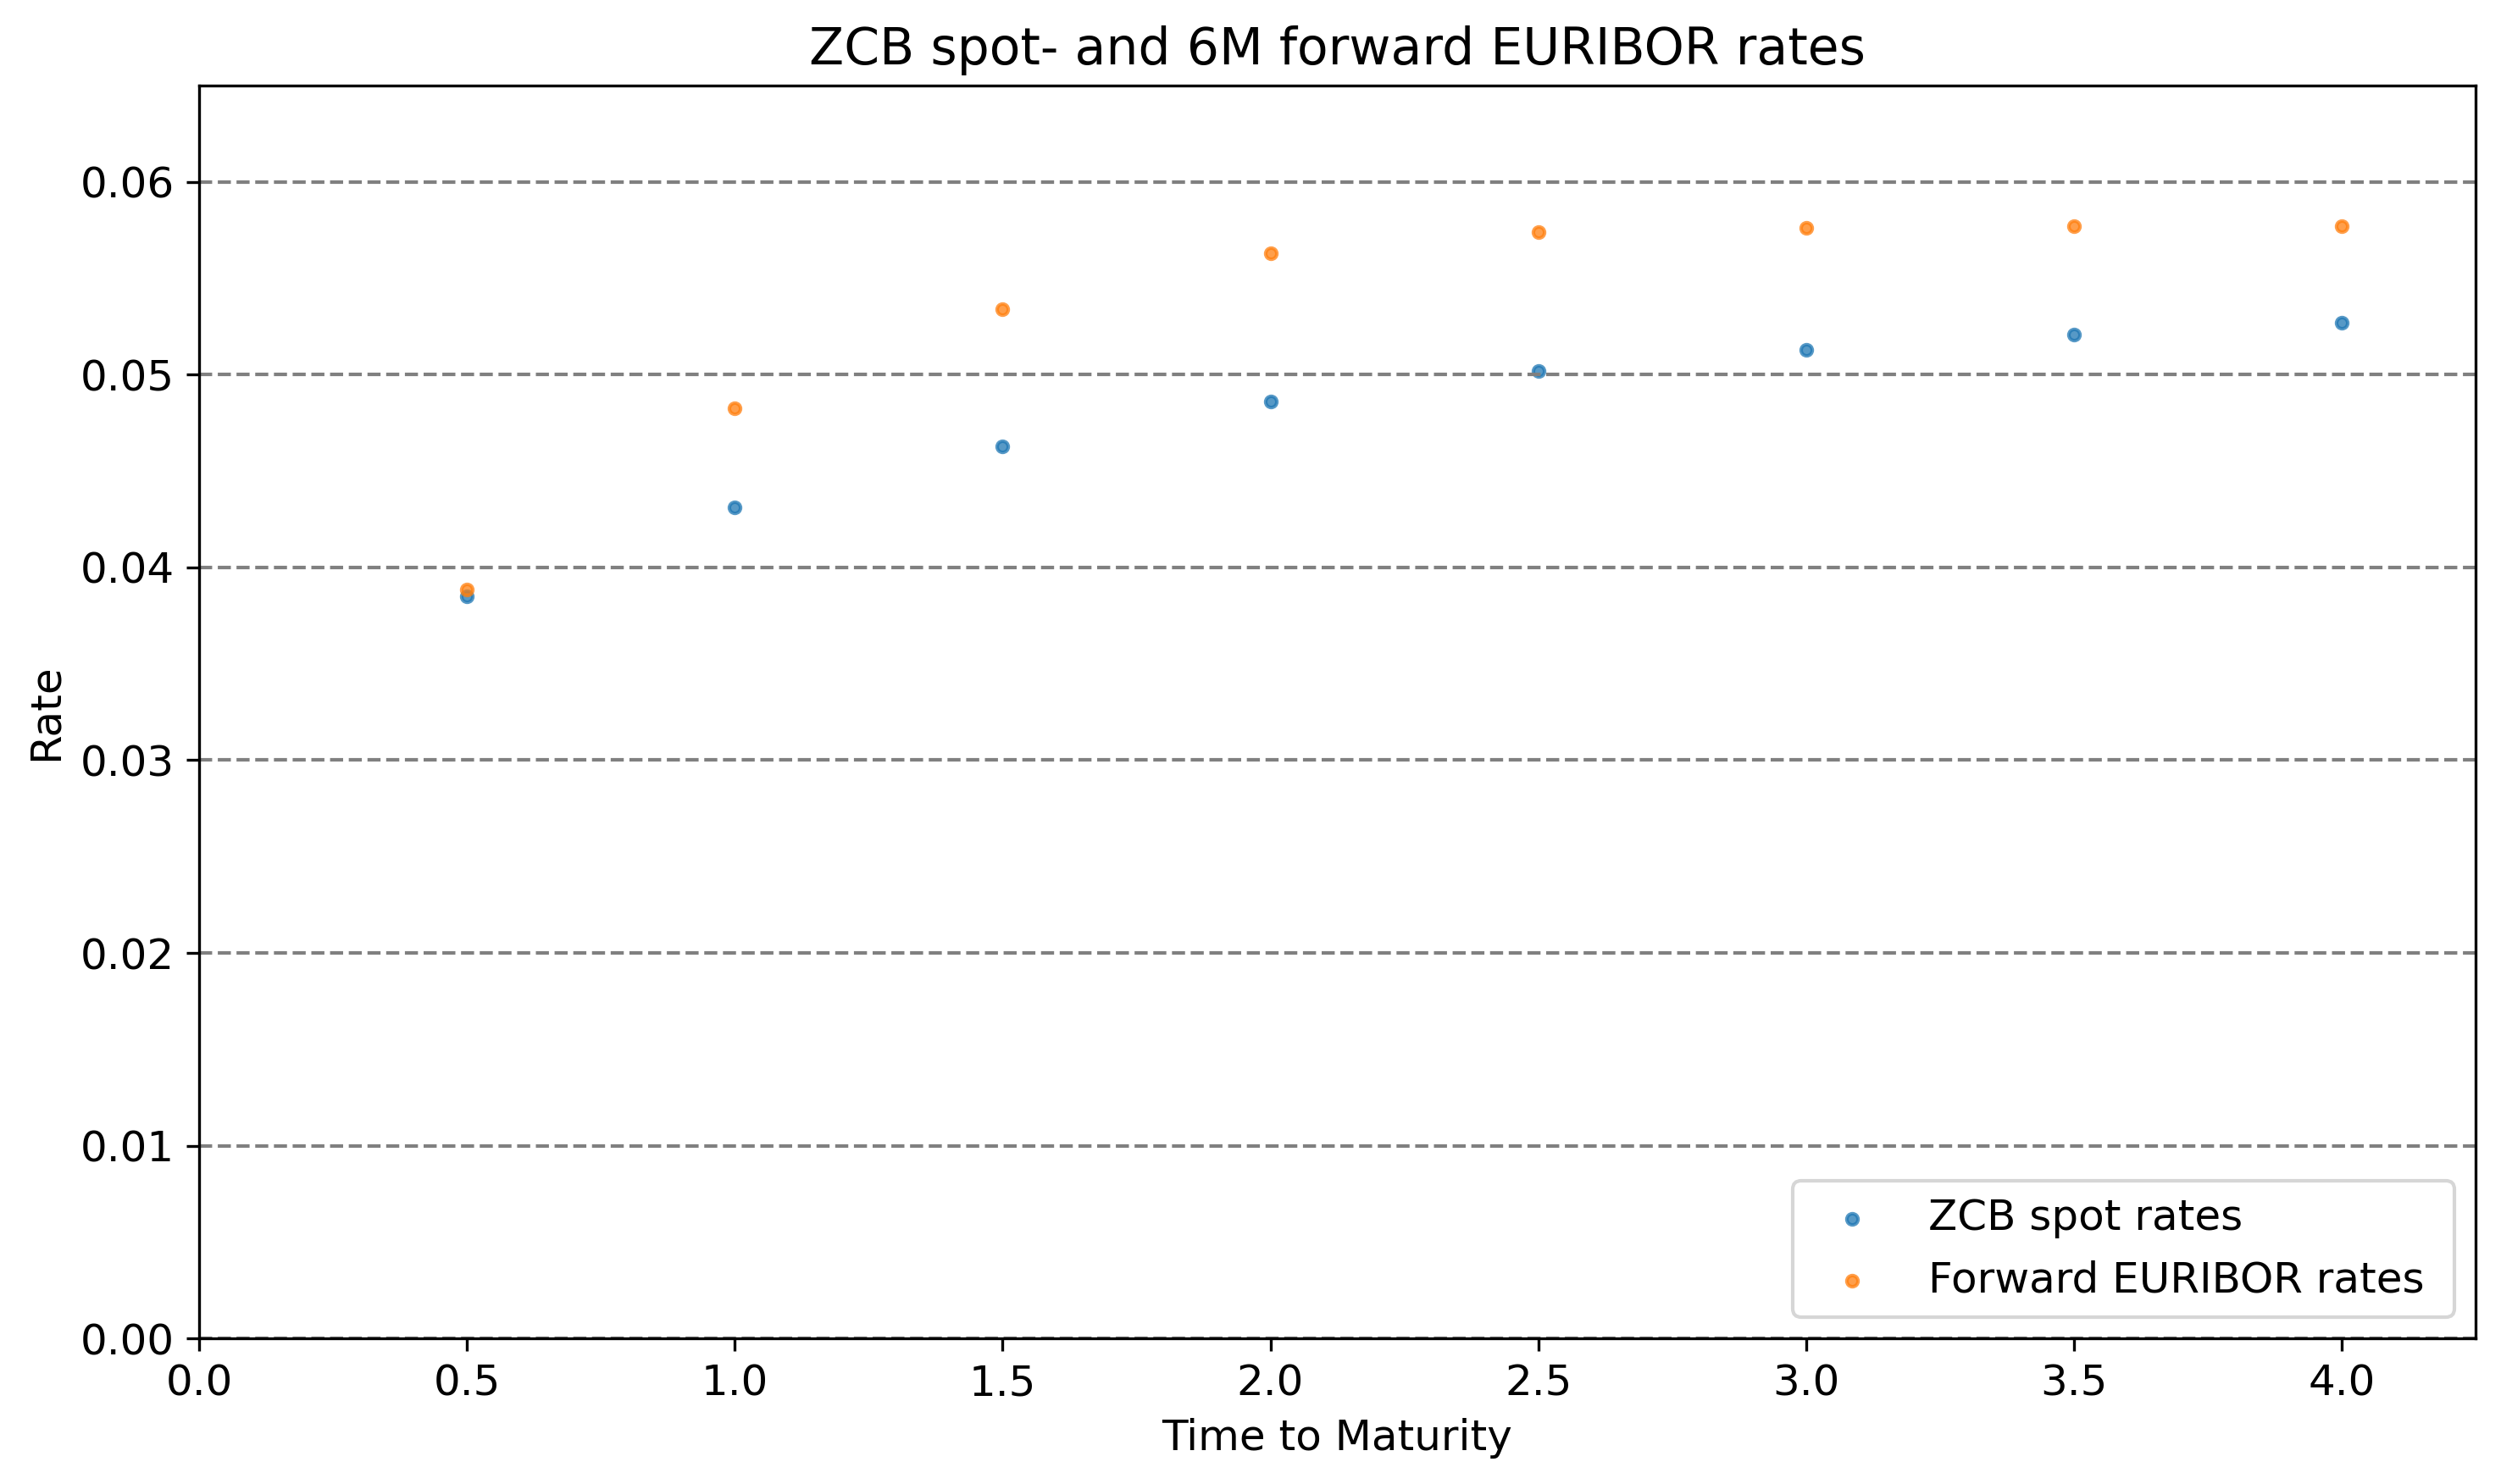

6M forward LIBOR:
[0.         0.03887295 0.04827337 0.05340046 0.05627724 0.0574085
 0.05761425 0.05771713 0.05771713]


In [13]:
M = 9
alpha = 0.5
T = np.linspace(0, 4, M)
spot_rate = np.array([np.nan, 0.0385,0.0431,0.0463,0.0486,0.0502,0.0513,0.0521,0.0527])
sigma_cap = np.array([np.nan, np.nan, 0.223, 0.241, 0.260, 0.283, 0.312, 0.355, 0.402])
p = fid.zcb_prices_from_spot_rates(T,spot_rate)
L = fid.forward_libor_rates_from_zcb_prices(T,p)
rates_plot = [{'label':'ZCB spot rates', 'x':T[1:], 'y':spot_rate[1:],'s':40},
              {'label':'Forward EURIBOR rates', 'x':T[1:], 'y':L[1:],'s':40}]
plot.rates(rates_plot, title = 'ZCB spot- and 6M forward EURIBOR rates', xrange=[0,4.25])
print(f'6M forward LIBOR:\n{L}')

#### b)

In [14]:
strike = 0.05
sigma_swap = 0.39
# convert all payments into fixed using 4Y interest swap
R_swap, S_swap = fid.swap_rate_from_zcb_prices(0,0,4,alpha,T,p)
print(f"Fixed rate: {R_swap}, Accrual factor: {S_swap}")

# buying interest cap to cap payments at 0.05
price_caplet = np.zeros([M])
for i in range(2,M):
    price_caplet[i] = fid.black_caplet_price(sigma_cap[i],T[i],strike,alpha,p[i],L[i],type = "call")
price_cap = sum(price_caplet)
R_cap = price_cap/S_swap
print(f"price_cap: {price_cap}, R_cap: {R_cap}, premium twice a year: {alpha*R_cap*10000:.5f} bps")

# buying a 2Y2Y swaption with strike 0.05
R_swap_forward, S_swap_forward = fid.swap_rate_from_zcb_prices(0,2,4,alpha,T,p)
price_swaption = fid.black_swaption_price(sigma_swap,T[int(2/alpha)],strike,S_swap_forward,R_swap_forward,type = "call")
R_swaption = price_swaption/S_swap
print(f"upfront cost of cap: {price_swaption} premium twice a year: {R_swaption*alpha*10000:.5f} bps")

Fixed rate: 0.05307796270952918, Accrual factor: 3.580845089117633
price_cap: 0.03929545631859573, R_cap: 0.010973793990143999, premium twice a year: 54.86897 bps
price_swaption: 0.02683993510220535, R_swaption: 0.007495419219271242, premium twice a year: 37.47710 bps


In [19]:
M = 9
alpha = 0.5
R = 0.05
T = np.array([i*alpha for i in range(0,M)])
spot_rate = np.array([np.nan,0.0385,0.0431,0.0463,0.0486,0.0502,0.0513,0.0521,0.0527])
sigma_caplet = np.array([np.nan,np.nan,0.223,0.241,0.260,0.283,0.312,0.355,0.402])
sigma_swaption = 0.39
# a)
p = fid.zcb_prices_from_spot_rates(T,spot_rate)
L = fid.forward_libor_rates_from_zcb_prices(T,p,horizon = 1)
print(f"6M forward LIBOR: {L}")
# b)
S_swap = 0
for i in range(1,M):
    S_swap += alpha*p[i]
R_swap = (1-p[M-1])/S_swap
print(f"S_swap: {S_swap}, R_swap: {R_swap}")
price_caplet = np.zeros([M])
for i in range(2,M):
    price_caplet[i] = fid.black_caplet_price(sigma_caplet[i],T[i],R,alpha,p[i],L[i],type = "call")
price_cap = sum(price_caplet)
R_cap = price_cap/S_swap
print(f"price_cap: {price_cap}, R_cap: {R_cap}, premium twice a year: {alpha*R_cap}")

S_swap_forward = 0
for i in range(5,M):
    S_swap_forward += alpha*p[i]
R_swap_forward = (p[4]-p[8])/S_swap_forward
price_swaption = fid.black_swaption_price(sigma_swaption,T[4],R,S_swap_forward,R_swap_forward,type = "call")
R_swaption = price_swaption/S_swap
print(f"price_swaption: {price_swaption}, R_swaption: {R_swaption}, premium twice a year: {R_swaption/2}")

6M forward LIBOR: [0.         0.03887295 0.04827337 0.05340046 0.05627724 0.0574085
 0.05761425 0.05771713 0.05771713]
S_swap: 3.580845089117633, R_swap: 0.05307796270952918
price_cap: 0.03929545631859573, R_cap: 0.010973793990143999, premium twice a year: 0.005486896995071999
price_swaption: 0.02683993510220535, R_swaption: 0.007495419219271242, premium twice a year: 0.003747709609635621


#### c)
i) Simply swapping the floating rate payments into a fixed stream of coupon payments eliminates all uncertainty. However, this choice also has no upside in the sense that if interest rates fall, the client will not benefit from future lower interest rate payments.

ii) Entering into an interest rate cap starting right now will insure that the interest payments will never rise above 0.05 so this limits the downside to the client at all future points in time. Also, there is a potential for upside in that the investor will benefit from low future interest rates. The strategy however comes at the cost that the investor will have to pay the premium of roughly 50 bp twice a year regardless of whether the cap comes into effect or not.

iii) Entering into a swaption with an exercise time in two years will insure that interest payments cannot exceed 0.05 from two years into the future and beyond. However, the client is not insured against rises in interest rates prior to the exercise time. This option is thus more risky than ii) and it therefore makes sense that it is less costly. This strategy like ii) has an upside in that the client will benefit from low future interest rates.

### Problem 4
#### a) 

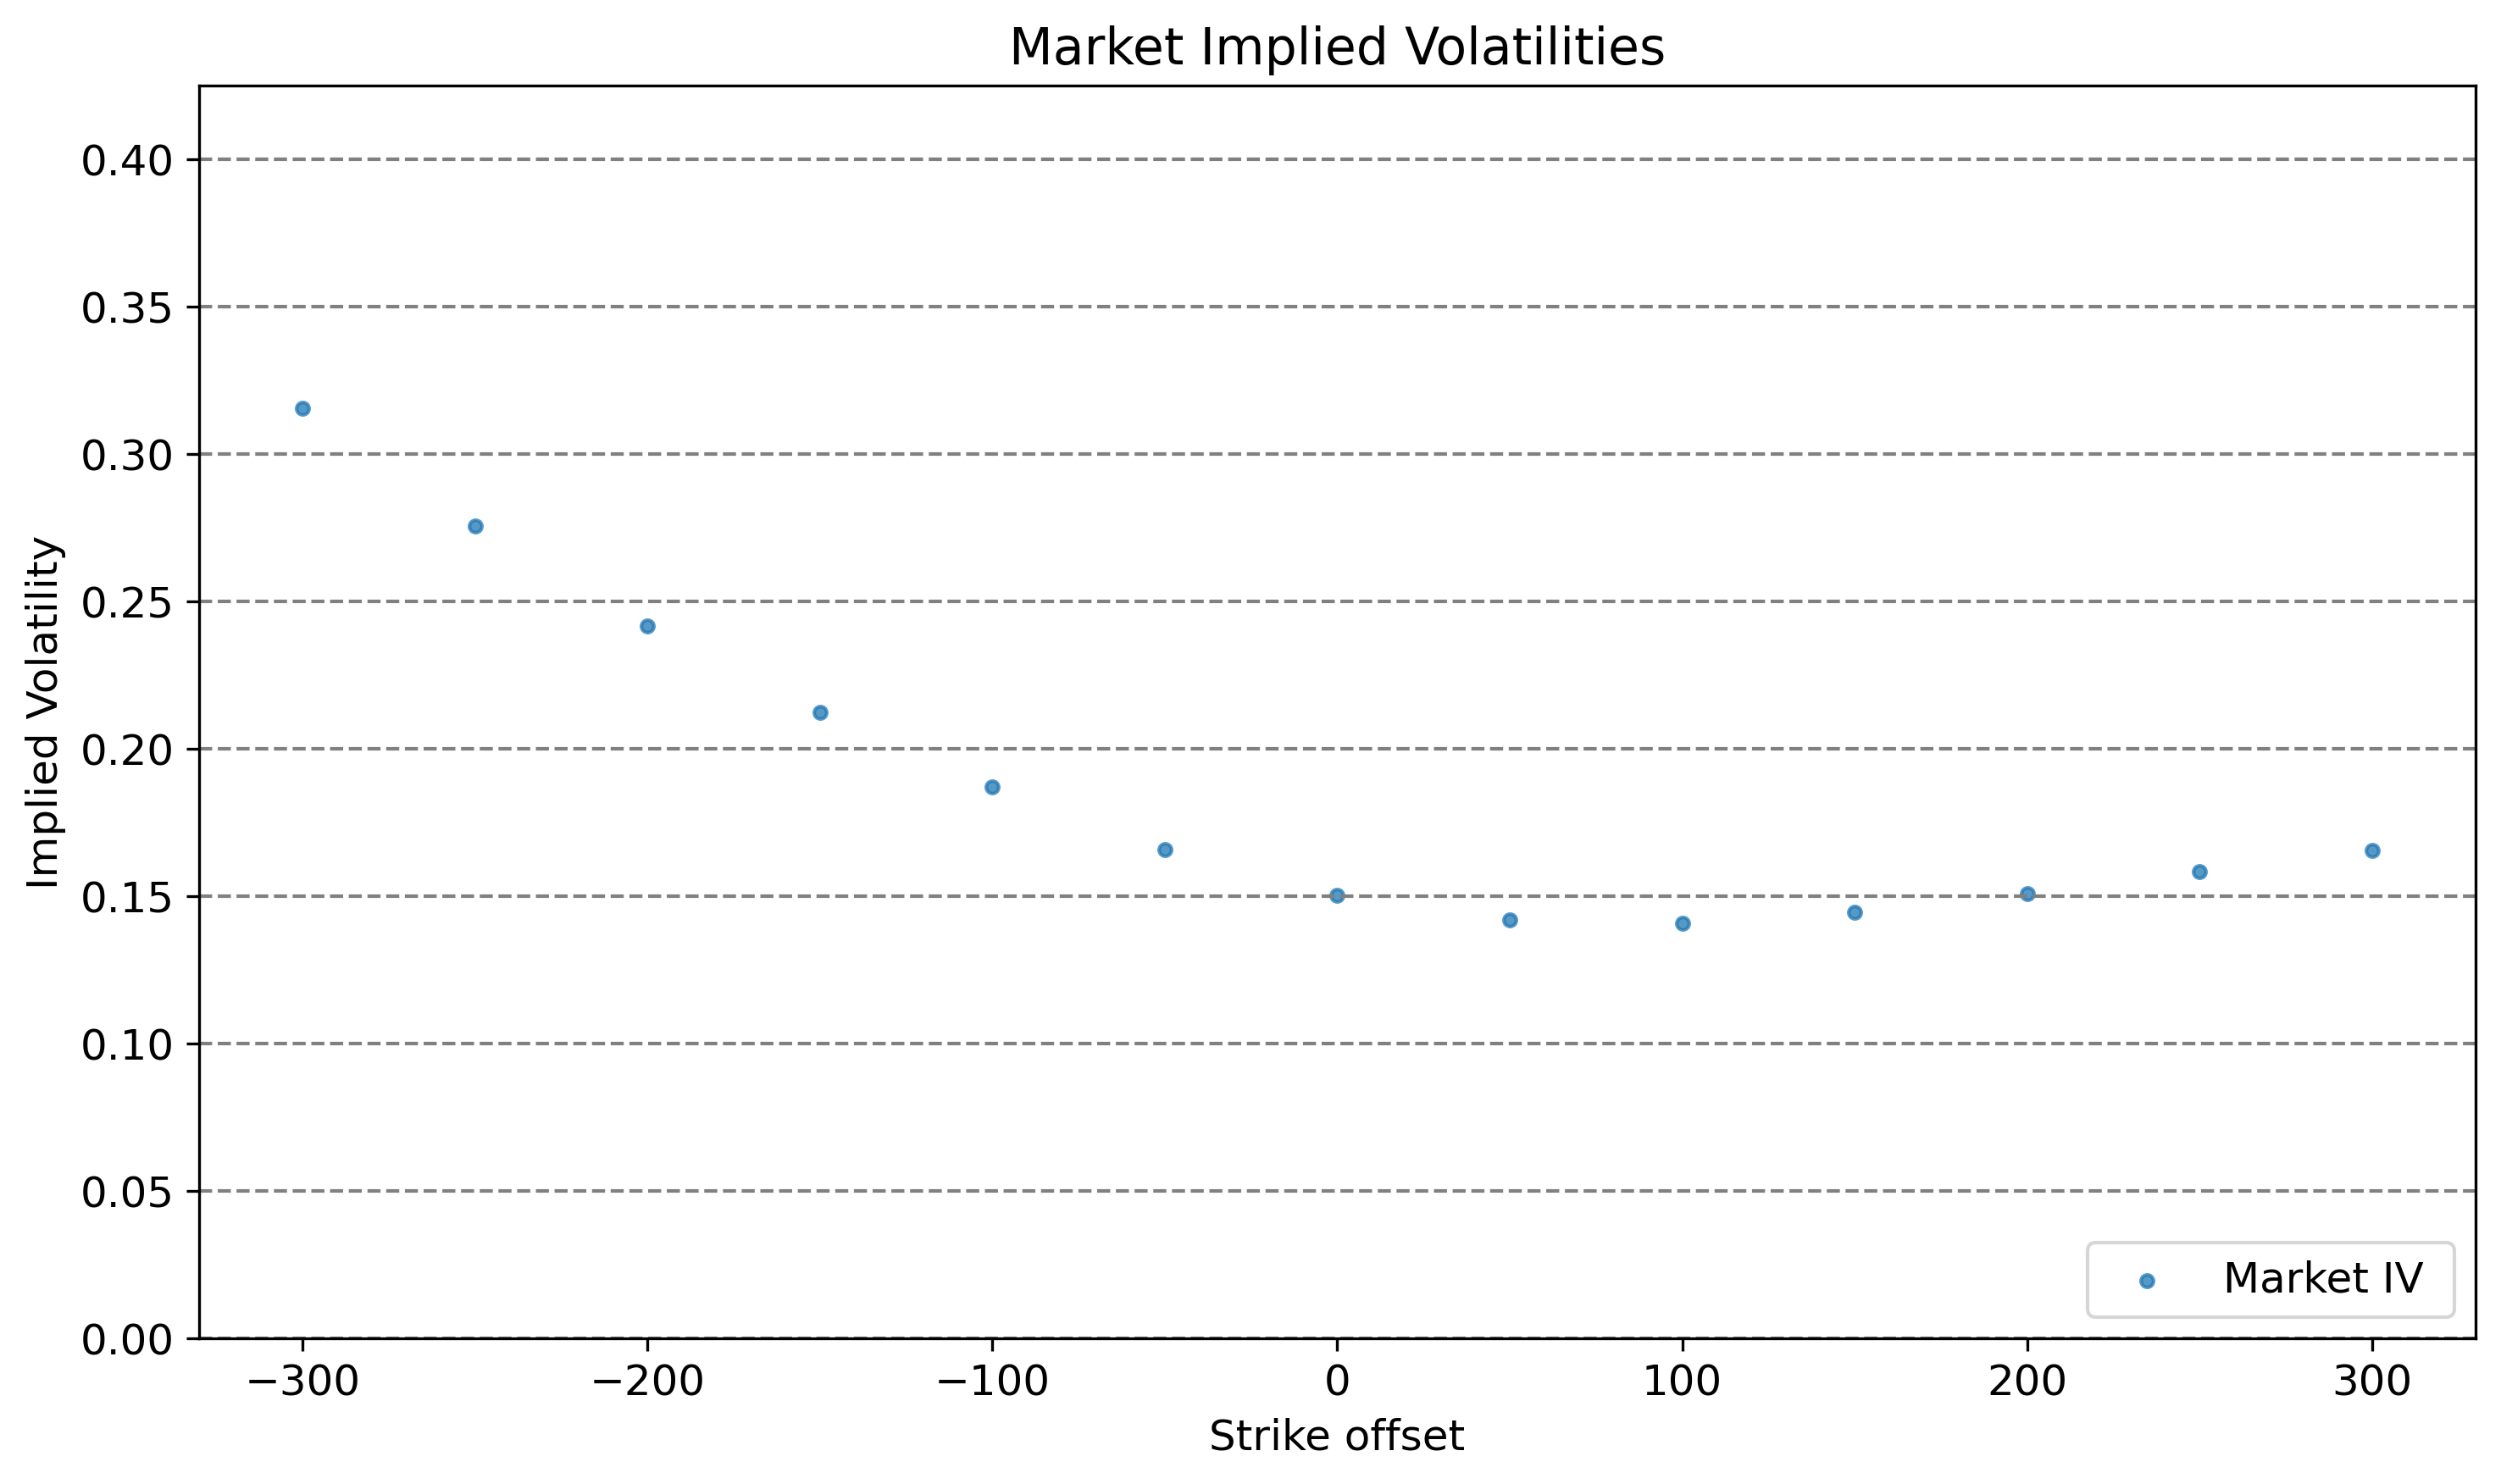

2Y4Y forward par swap rate: 0.053115709145571254, accrual factor: 3.2979710300000002
market implied volatility: 
[0.31555267 0.27571732 0.2417579  0.21251243 0.18717002 0.16594365
 0.15032339 0.1418881  0.14075951 0.14458939 0.15091799 0.15822536
 0.16563506]


In [15]:
M = 6*2+1
T = np.linspace(0, 6, M)
idx_exercise = 4
price_swap_market = np.array([0.0995524,0.08350629,0.06774531,0.05248227,0.03808218,0.02519355,0.01482874,0.00785645,0.00404525,0.00219232,0.00128815,0.00081635,0.00054773])
p = np.array([1,0.98322948,0.96455878,0.94449414,0.92344747,0.90175113,0.87967118,0.85741902,0.83516131,0.81302835,0.79112104,0.76951663,0.7482734])
R_swap, S_swap = fid.swap_rate_from_zcb_prices(0,2,6,'semiannual',T,p)
K_offset = np.linspace(-300,300,13)
K, iv_market = np.zeros([M]), np.zeros([M])
for i in range(M):
    K[i] = R_swap + K_offset[i]/10000
    iv_market[i] = fid.black_swaption_iv(price_swap_market[i],T[idx_exercise],K[i],S_swap,R_swap,type = "call") # call because it is payer swaption
iv_plot = [{'label':'Market IV','x':K_offset,'y':iv_market, 's':50}]
plot.rates(iv_plot, title='Market Implied Volatilities', xlabel='Strike offset', ylabel='Implied Volatility', yrange=[0,0.425])
print(f"2Y4Y forward par swap rate: {R_swap}, accrual factor: {S_swap}")
print(f'market implied volatility: \n{iv_market}')

The observed implied volatility smile clearly indicates that the market is not pricing swaptions according to Black’s model. Instead, the market implies a distribution for the 2Y4Y forward par swap rate that exhibits skewness and heavier tails compared to the log-normal distribution assumed by Black’s model.

**From solution**:
There is a ’smirk’ in implied volatilities clearly indicating that market prices are not equivalent to what would arise in a Black’s model. The pricing measure chosen by the market is not compatible with the 2Y 4Y forward par swap rate following a log-normal distribution. The distribution implied by the measure chosen by the market has more fat tails and displays more left skewness than that of a log-normal random variable. This is a finding that is very much consistent with typical market behavior

#### b)

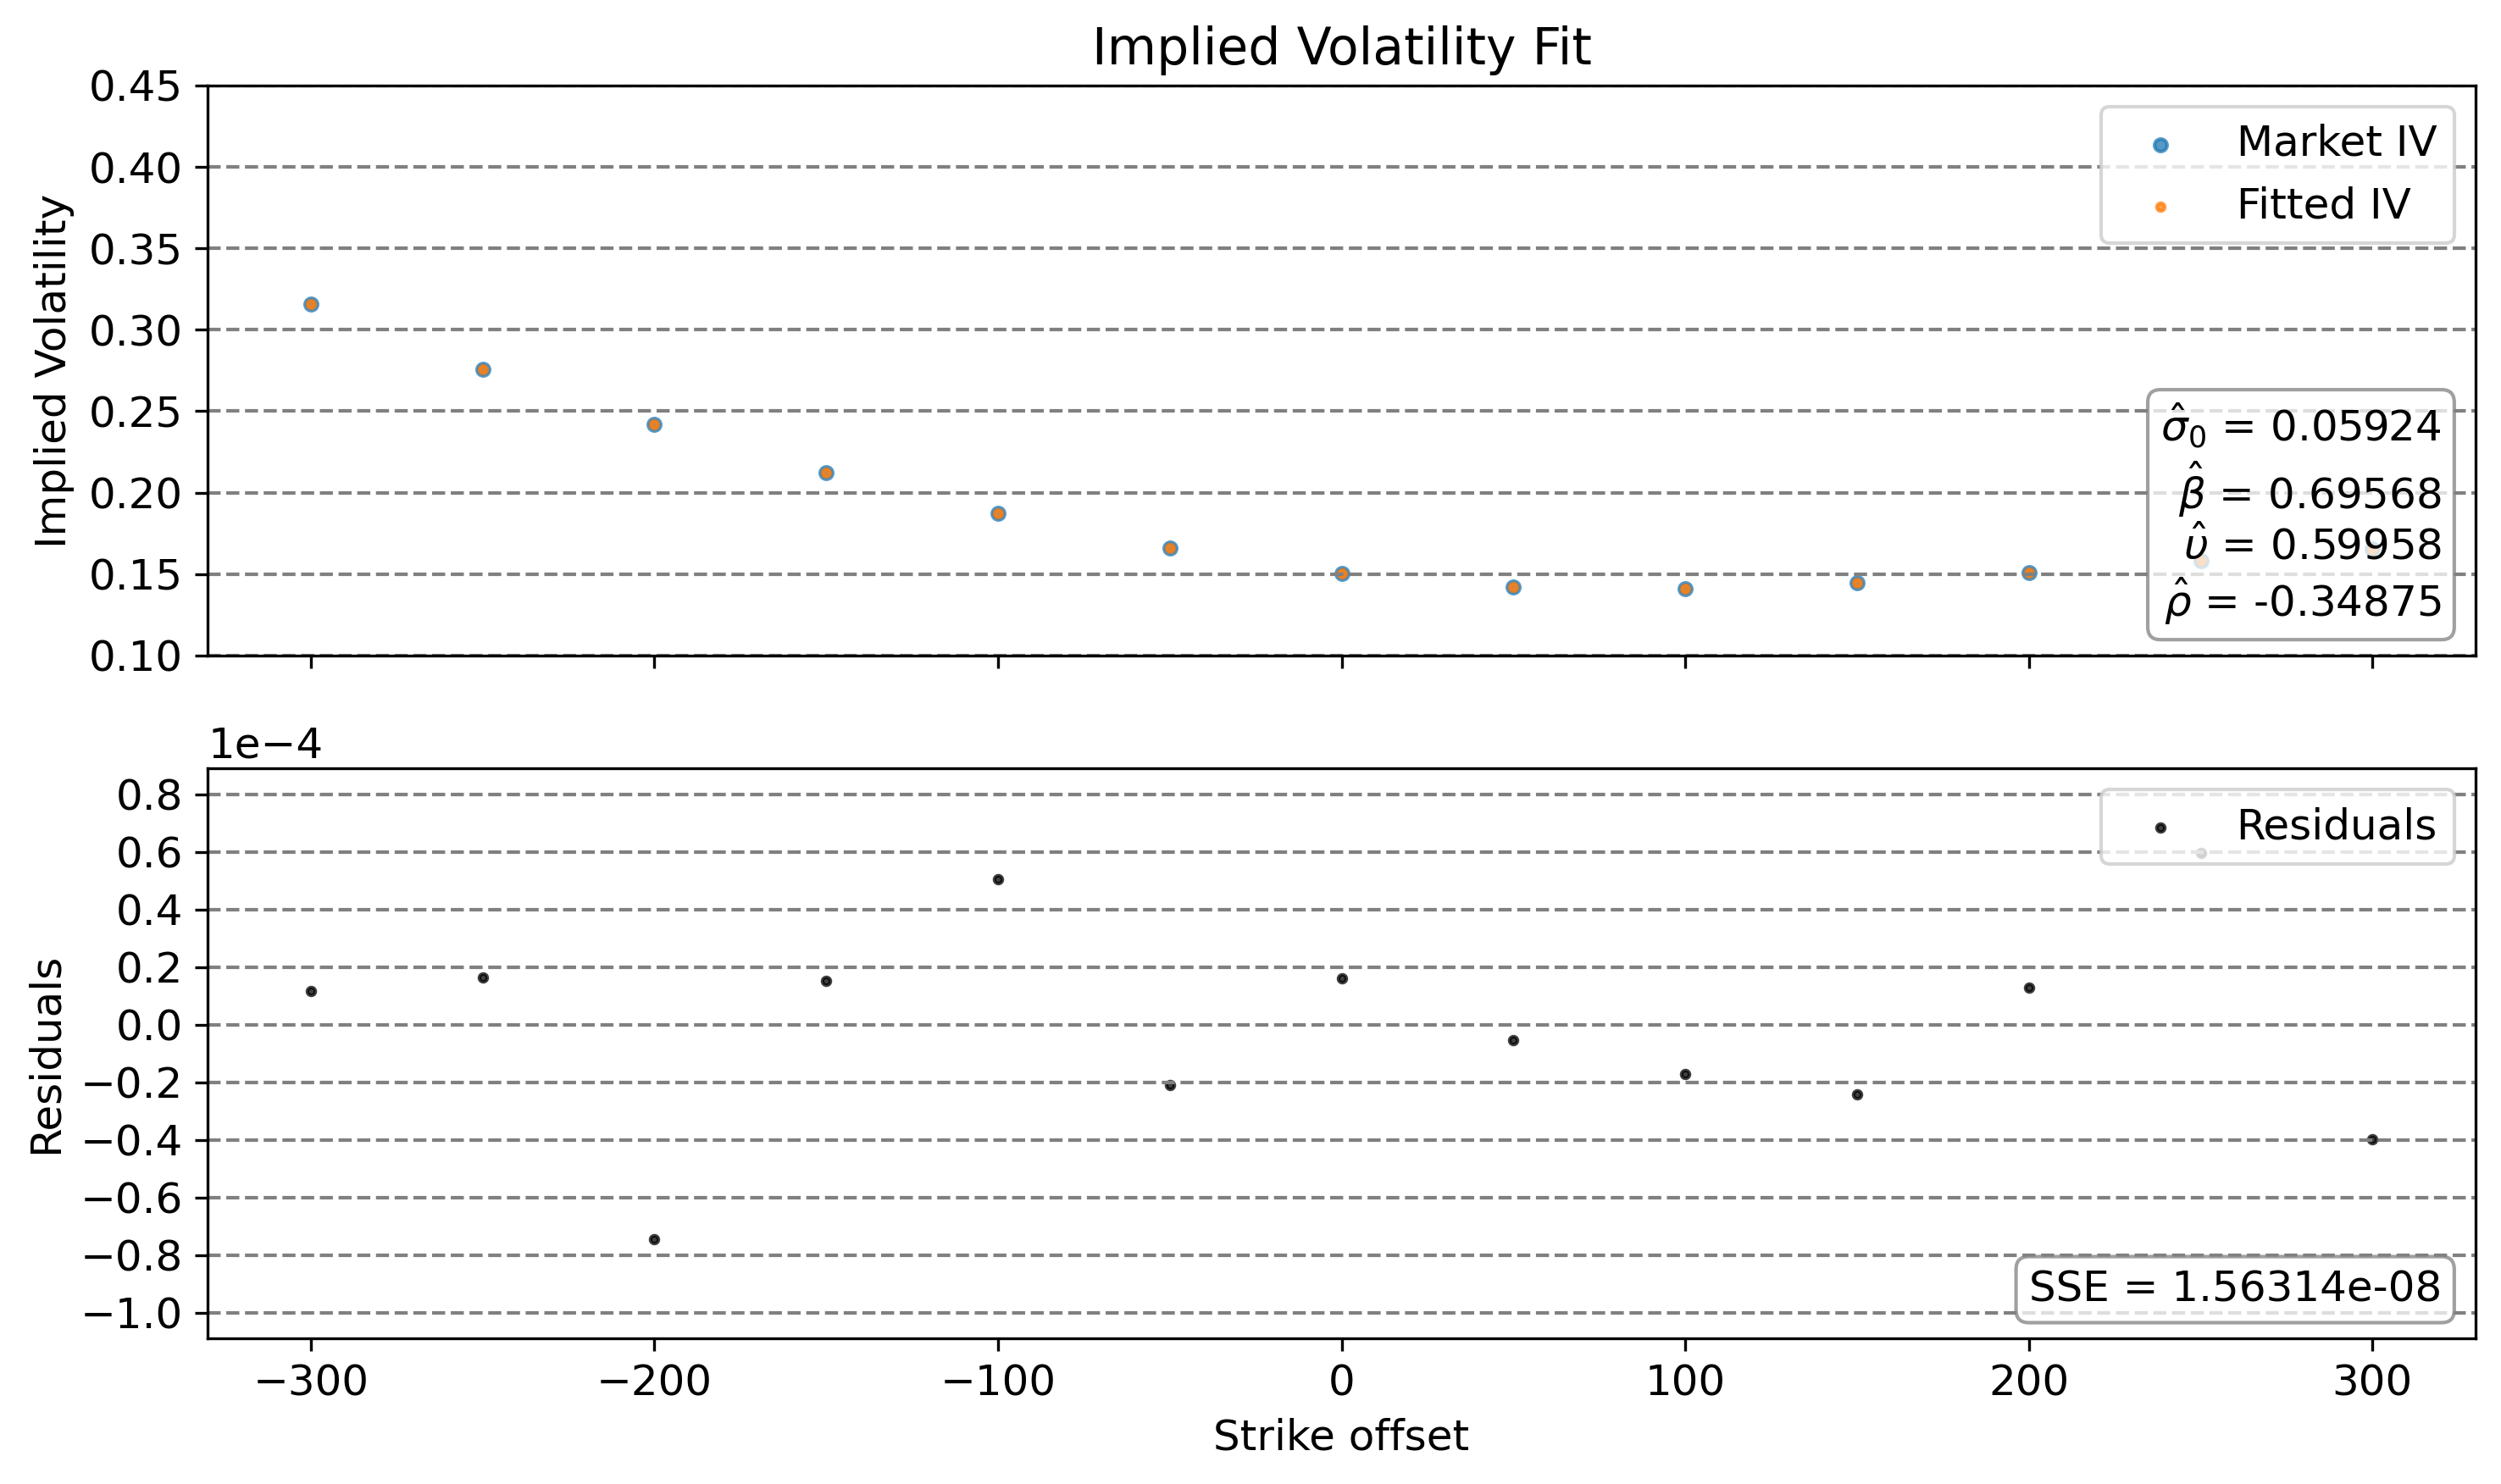

In [16]:
param0 = 0.04, 0.5, 0.4, -0.3
result = minimize(fid.fit_sabr_obj, param0, method = 'nelder-mead', args = (iv_market,K,T[idx_exercise],R_swap) ,options={'xatol': 1e-8,'disp': False})
sigma0, beta, upsilon, rho = result.x
iv_fit, price_fit = np.zeros([M]), np.zeros([M])
for i in range(M):
    iv_fit[i] = fid.sigma_sabr(K[i],T[idx_exercise],R_swap,sigma0,beta,upsilon,rho,type = "call")
    price_fit[i] = fid.black_swaption_price(iv_fit[i],T[idx_exercise],K[i],S_swap,R_swap,type = "call")
iv_plot.append({'label':'Fitted IV','x':K_offset,'y':iv_fit})
res = [{'label':'Residuals','x':K_offset,'y':iv_market-iv_fit}]
text = {'$\hat{\sigma}_0$':sigma0,'$\hat{\\beta}$':beta,'$\hat{\\upsilon}$':upsilon,'$\hat{\\rho}$':rho}
text_res = {'SSE':result.fun}
plot.fit(iv_plot,res,'Implied Volatility Fit',xlabel='Strike offset', ylabel='Implied Volatility', text=text, text_res=text_res)

As seen above the fitted implied volatility from the SABR model perfectly matches the data with a residual SSE of $1.56\cdot 10^{-8}$

#### c)


In [17]:
idx_position = 4
idx_maturity = 12
# Bumping upsilon
upsilon_bump = upsilon - 0.02
sigma_upsilon = fid.sigma_sabr(K[idx_position],T[idx_exercise],R_swap,sigma0,beta,upsilon_bump,rho,type = "call")
price_upsilon = fid.black_swaption_price(sigma_upsilon,T[idx_exercise],K[idx_position],S_swap,R_swap,type = "call")
print(f"price after bumping upsilon: {price_upsilon}, diff: {price_upsilon-price_swap_market[idx_position]}")
# Bumping rho
rho_bump = rho + 0.1
sigma_rho = fid.sigma_sabr(K[idx_position],T[idx_exercise],R_swap,sigma0,beta,upsilon,rho_bump,type = "call")
price_rho = fid.black_swaption_price(sigma_rho,T[idx_exercise],K[idx_position],S_swap,R_swap,type = "call")
print(f"price after bumping rho: {price_rho}, diff: {price_rho- price_swap_market[idx_position]}")
# Bumping the entire spot rate curve
R = fid.spot_rates_from_zcb_prices(T,p)
R_bump = R - 0.0001*np.ones([M])
p_bump = fid.zcb_prices_from_spot_rates(T,R_bump)
R_swap_bump, S_bump = fid.swap_rate_from_zcb_prices(0,T[idx_exercise],T[idx_maturity],'semiannual',T,p_bump)
sigma_delta = fid.sigma_sabr(K[idx_position],T[idx_exercise],R_swap_bump,sigma0,beta,upsilon,rho,type = "call")
price_delta = fid.black_swaption_price(sigma_delta,T[idx_exercise],K[idx_position],S_bump,R_swap_bump,type = "call")
print(f"price after bumping spot rates: {price_delta}, diff: {price_delta-price_swap_market[idx_position]}")

price after bumping upsilon: 0.03796525384557069, diff: -0.00011692615442931292
price after bumping rho: 0.03788178565559886, diff: -0.00020039434440113912
price after bumping spot rates: 0.03779820829743131, diff: -0.00028397170256869164
